## Pruebas de seguimiento solar y demanda neta

# Funciones y datos

In [1]:
# Importamos librerías
import os
import numpy                           as np
import pandas                          as pd
import xarray                          as xr
from   matplotlib        import pyplot as plt
from   scipy             import stats
from   scipy             import optimize
from   scipy             import interpolate
from   matplotlib.ticker import StrMethodFormatter

In [2]:
# Funciones trigonométricas.
def sin(x) : return np.sin(np.radians(x))
def cos(x) : return np.cos(np.radians(x))
def tan(x) : return np.tan(np.radians(x))
def asin(x): return np.arcsin(x) * 180/np.pi
def acos(x): return np.arccos(x) * 180/np.pi
def atan(x): return np.arctan(x) * 180/np.pi

# Funciones para claves de regiones eléctricas

# Clave a número
def NUM_REGION(x):
    if   x == "BCA"  : y = 1
    elif x == "BCS"  : y = 2
    elif x == "CEN"  : y = 3
    elif x == "NES"  : y = 4
    elif x == "NOR"  : y = 5
    elif x == "NTE"  : y = 6
    elif x == "OCC"  : y = 7
    elif x == "ORI"  : y = 8
    elif x == "PEN"  : y = 9
    elif x == "PGE"  : y = 10
    elif x == "SCE"  : y = 11
    elif x == "SDGE" : y = 12
    elif x == "VEA"  : y = 13
    elif x == "COAST": y = 14
    elif x == "EAST" : y = 15
    elif x == "FWEST": y = 16
    elif x == "NORTH": y = 17
    elif x == "NCENT": y = 18
    elif x == "SOUTH": y = 19
    elif x == "SCENT": y = 20
    elif x == "WEST" : y = 21
    elif x == "LON"  : y = 22
    elif x == "LAT"  : y = 23
    elif x == "TOTAL": y = 24
    return y

# Número a clave
def NUM_REGION_r(x):
    if   x == 1 : y = "BCA"
    elif x == 2 : y = "BCS"
    elif x == 3 : y = "CEN"
    elif x == 4 : y = "NES"
    elif x == 5 : y = "NOR"
    elif x == 6 : y = "NTE"
    elif x == 7 : y = "OCC"
    elif x == 8 : y = "ORI"
    elif x == 9 : y = "PEN"
    elif x == 10: y = "PGE"
    elif x == 11: y = "SCE"
    elif x == 12: y = "SDGE"
    elif x == 13: y = "VEA"
    elif x == 14: y = "COAST"
    elif x == 15: y = "EAST"
    elif x == 16: y = "FWEST"
    elif x == 17: y = "NORTH"
    elif x == 18: y = "NCENT"
    elif x == 19: y = "SOUTH"
    elif x == 20: y = "SCENT"
    elif x == 21: y = "WEST"
    elif x == 22: y = "LON"
    elif x == 23: y = "LAT"
    elif x == 24: y = "TOTAL"
    return y

# Número a nombre
def NAME_REGION_r(x):
    if   x == 1 : y = "Baja California"
    elif x == 2 : y = "Baja California Sur"
    elif x == 3 : y = "Centro"
    elif x == 4 : y = "Noreste"
    elif x == 5 : y = "Noroeste"
    elif x == 6 : y = "Norte"
    elif x == 7 : y = "Occidente"
    elif x == 8 : y = "Oriente"
    elif x == 9 : y = "Peninsular"
    elif x == 10: y = "Pacific G&E"
    elif x == 11: y = "Southern Cal Edison"
    elif x == 12: y = "San Diego G&E"
    elif x == 13: y = "Valley Electric Assn"
    elif x == 14: y = "Coast"
    elif x == 15: y = "East"
    elif x == 16: y = "Far West"
    elif x == 17: y = "North"
    elif x == 18: y = "North Central"
    elif x == 19: y = "South"
    elif x == 20: y = "South Central"
    elif x == 21: y = "West"
    elif x == 22: y = "Longitudinal"
    elif x == 23: y = "Latitudinal"
    elif x == 24: y = "Total"
    return y

In [3]:
# Casos de orientación de sistemas fotovoltaico

# Casos a estudiar
cases = [ "south_no_track", "west_no_track", "east_no_track",
    "1_track", "2_track", "bifacial_vertical_west_main",
    "bifacial_vertical_east_main", "bifacial_vertical_west_back",
    "bifacial_vertical_east_back", "bifacial_south_back" ]
# Variables fotovoltaicas por caso
# Inclinación
track_tilt       =   [ f"{x}_Tilt"               for x in cases ]
# Azimuth
track_azimuth    =   [ f"{x}_Azimuth"            for x in cases ]
# Ángulo entre el panel y el sol, Angle of Incidence
track_AOI        =   [ f"{x}_Angle_of_Incidence" for x in cases ]
# Radiación incidente en el panel [W/m^2], Plane of Array Irradiace
track_POA        =   [ f"{x}_POA"                for x in cases ]
# Producción fotovoltaica por kilowatt de capacidad [W/kWp]
track_P_mp       = ( [ f"{x}_P_mp"               for x in cases ]
    + [ "bifacial_vertical_west_P_mp",
        "bifacial_vertical_east_P_mp",
        "bifacial_south_P_mp" ] )
# Producción para cada caso
prod_n           = track_P_mp[0:5] + track_P_mp[10:]
# Factor bifacial
P_bf = [ 1, 1, 1, 1, 1, 1, 1, 0.7, 0.7, 0.7 ]

prod_n_dist = [f"{x}_distributed" for x in prod_n]
prod_n_centr = [f"{x}_central" for x in prod_n]
prod_n_total = [f"{x}_total" for x in prod_n]
prod_n_i = prod_n + prod_n_dist + prod_n_centr + prod_n_total

In [4]:
# Datos de radiación

# Rutas de archivos
dir_r = "/datos/rodr/temp/recurso_solar/duck_curve/"
ds_c = xr.open_dataset(f"{dir_r}full_disc_region_2022.nc")
ds_c["timezone_round"] = np.around(ds_c["timezone"]).astype(int)
for t in np.unique(ds_c["timezone_round"]): ds_c = xr.where(
    ds_c["timezone_round"] == t, ds_c.shift({"time": t}), ds_c )
ds_c

<xarray.Dataset> Size: 27MB
Dimensions:                                  (REGION: 24, time: 8760)
Coordinates:
  * REGION                                   (REGION) int64 192B 1 2 3 ... 23 24
  * time                                     (time) datetime64[ns] 70kB 2022-...
Data variables: (12/40)
    south_no_track_P_mp                      (REGION, time) float32 841kB 0.0...
    west_no_track_P_mp                       (REGION, time) float32 841kB 0.0...
    east_no_track_P_mp                       (REGION, time) float32 841kB 0.0...
    1_track_P_mp                             (REGION, time) float32 841kB 0.0...
    2_track_P_mp                             (REGION, time) float32 841kB 0.0...
    bifacial_vertical_west_P_mp              (REGION, time) float32 841kB 0.0...
    ...                                       ...
    1_track_P_mp_total                       (REGION, time) float32 841kB 0.0...
    2_track_P_mp_total                       (REGION, time) float32 841kB 0.0...
    bifacial_vertical_west_P_mp_total        (REGION, time) float32 841kB 0.0...
    bifacial_vertical_east_P_mp_total        (REGION, time) float32 841kB 0.0...
    bifacial_south_P_mp_total                (REGION, time) float32 841kB 0.0...
    timezone_round                           (REGION) int64 192B -8 -7 ... -8 -8

# Demanda

In [ ]:
# Cargamos la demanda

# CENACE
# Ruta de la demanda para México
path_d = "/home/rodr/Datos/recurso_solar/Demanda/"
path_f = f"{path_d}Mexico/Original/"
# Cargamos cada archivo
df_i = []
files = os.listdir(path_f)
files.sort()
for f in files:
    if f[0] != ".":
        df_0 = pd.read_csv(path_f + f, skiprows = 8,
            na_values = "               ---" )
        # Asignamos columnas
        df_0.columns = ["Sistema", "Area", "Hora", "Generacion (MWh)",
            "Importacion Total (MWh)", "Exportacion Total (MWh)",
            "Intercambio neto entre Gerencias (MWh)",
            "Estimacion de Demanda por Balance (MWh)"]
        df_0 = df_0[ ["Sistema", "Area", "Hora",
            "Estimacion de Demanda por Balance (MWh)"] ]
        df_0["Area"] = df_0["Area"].where(
            df_0["Area"]!="BCA", df_0["Sistema"] )
        df_0 = df_0.drop(columns = "Sistema")
        # Damos formato a la fecha
        df_0["Fecha"] = f[40:50]
        df_i.append(df_0)
df_cenace = pd.concat(df_i)
df_i = []
for c in df_cenace["Area"].unique():
    df_i.append(df_cenace[df_cenace["Area"] == c].copy())
for i in range(len(df_i)):
    df_i[i]["time"] = pd.date_range("2022-01-01", periods = 8760, freq = "h")
demanda = "Estimacion de Demanda por Balance (MWh)"
df_cenace = pd.concat(df_i).rename( columns =
    {demanda: "Demand", "Area": "REGION"} )
df_cenace["REGION"] = df_cenace["REGION"].apply(NUM_REGION)
df_cenace = df_cenace.set_index(["REGION", "time"]).drop(
    columns = ["Fecha", "Hora"]).sort_index()
# Interpolamos para rellenar el apagón en Yucatán
a = df_cenace.iloc[74214: 74220].values
df_cenace.iloc[74214: 74220] = interpolate.CubicSpline([0, 1, 4, 5],
    a[[0, 1, 4, 5]])([0, 1, 2, 3, 4, 5])

# ERCOT
path_ercot = f"{path_d}ERCOT/Native_Load_2022.xlsx"
df_ercot = pd.read_excel(path_ercot)
df_ercot["time"] = pd.date_range("2022-01-01", periods = 8760, freq = "h")
df_ercot = df_ercot.set_index("time").drop(columns = ["Hour Ending", "ERCOT"])
df_ercot = df_ercot.stack().reset_index(level = 1).rename(
    columns = {"level_1": "REGION", 0: "Demand"})
df_ercot["REGION"] = df_ercot["REGION"].apply(NUM_REGION)
df_ercot = df_ercot.set_index("REGION", append = True
    ).swaplevel("REGION", "time")

#CAISO
path_caiso = f"{path_d}CAISO/historicalemshourlyload-2022.xlsx"
df_caiso = pd.read_excel(path_caiso)
df_caiso["time"] = pd.date_range("2022-01-01", periods = 8760, freq = "h")
df_caiso = df_caiso.set_index("time").drop(columns = ["Date", "HR", "CAISO"])
df_caiso = df_caiso.stack().reset_index(level = 1).rename(
    columns = {"level_1": "REGION", 0: "Demand"})
df_caiso["REGION"] = df_caiso["REGION"].apply(NUM_REGION)
df_caiso = df_caiso.set_index("REGION", append = True
    ).swaplevel("REGION", "time")

# Unimos las regiones
ds_d = pd.concat( [df_ercot, df_caiso, df_cenace]
    ).sort_index().to_xarray()

ds_d["timezone_round"] = ds_c["timezone_round"]
# Datos agregados para generación
# Agrupamiento longitudinal
ds_i = ds_d.where(ds_d["REGION"].isin([1, 2, 4, 5, 6, 14, 19]))
for t in np.unique(ds_i["timezone_round"]): 
    if not np.isnan(t): ds_i = xr.where(
        ds_i["timezone_round"] == t, ds_i.shift({"time": -(int(t)+8)}), ds_i )
ds_i["REGION"] = ds_i["REGION"].where(ds_i["REGION"] == 22, 22)
ds_d_2 = ds_i.groupby("REGION").sum()
# Agrupamiento latitudinal
ds_i = ds_d.where(ds_d["REGION"].isin([1, 2, 10, 11, 12, 13]))
for t in np.unique(ds_i["timezone_round"]): 
    if not np.isnan(t): ds_i = xr.where(
        ds_i["timezone_round"] == t, ds_i.shift({"time": -(int(t)+8)}), ds_i )
ds_i["REGION"] = ds_i["REGION"].where(ds_i["REGION"] == 23, 23)
ds_d_3 = ds_i.groupby("REGION").sum()
# Agrupamiento total
ds_i = ds_d.copy()
for t in np.unique(ds_i["timezone_round"]): 
    if not np.isnan(t): ds_i = xr.where(
        ds_i["timezone_round"] == t, ds_i.shift({"time": -(int(t)+8)}), ds_i )
ds_i["REGION"] = ds_i["REGION"].where(ds_i["REGION"] == 24, 24)
ds_d_4 = ds_i.groupby("REGION").sum()
ds_d = xr.concat([ds_d, ds_d_2, ds_d_3, ds_d_4], "REGION")
ds_d["REGION"] = ds_d["REGION"].astype(int)

ds_d["hour"] = ds_d["time"].dt.hour.copy()
ds_d["dayofyear"] = ds_d["time"].dt.dayofyear.copy()
ds_c["hour"] = ds_c["time"].dt.hour.copy()
ds_c["dayofyear"] = ds_c["time"].dt.dayofyear.copy()

# Unimos demanda y producción
ds_c["Demand"] = ds_d["Demand"]

In [60]:
# Minimun capacity to reach zero net demand during duck's belly
prod_n_cap = [f"{x}_capacity" for x in prod_n_i]
# Función que determina la demanda mínima en términos de la capacidad
def demand(x, v, c):
    return (ds_c["Demand"] - ds_c[v] * x).sel({"REGION": c}).pipe(np.min)
# Encontramos la capacidad que ocasiona una demanda nula
for i, v in enumerate(prod_n_i):
    n = []
    x0 = 5e7
    for c in ds_c["REGION"].values:
        #if c in [22, 23]: x0 = 5e4
        #elif c in [24]: x0 = 5e5
        #else: x0 = 5e3
        n.append( optimize.fsolve( demand, x0 = x0, args = (v, c))[0] / 1000 )
    ds_c[prod_n_cap[i]] = ("REGION", n)
ds_c["min_capacity"] = ( "REGION",
    ds_c[prod_n_cap].to_dataframe().min(axis = 1).values )

# Net demand with capacity that produces zero demand
# Demanda neta [MW]
names_dn = ["South-facing", "West-facing", "East-facing",
    "1 axis tracking", "2 axis tracking", "Bifacial, vertical, west-facing",
    "Bifacial, vertical, east-facing", "Bifacial, south facing", ]
names_dn_t = ( names_dn + [f"{x}_distributed" for x in names_dn]
    + [f"{x}_central" for x in names_dn]
    + [f"{x}_total" for x in names_dn] )
track_net_demand = [ f"{x}_net_demand"  for x in names_dn_t ]
ds_c[track_net_demand] = ( ds_c["Demand"]
    - ds_c[prod_n_i] * ds_c[prod_n_cap].rename(
    dict(zip(prod_n_cap, prod_n_i))) * 1000 )
# Net demand with same capacity for all cases
prod_dn_min = [f"{x}_min" for x in track_net_demand]
ds_c[prod_dn_min] = ( ds_c["Demand"]
    - ds_c[prod_n_i] * ds_c["min_capacity"] * 1000 )
# Energy produced
ener = [ f"{x}_energy" for x in prod_n_i ]
ds_c[ener] = ( ds_c[prod_n_i]
    * ds_c[prod_n_cap].rename(dict(zip(prod_n_cap, prod_n_i))) / 1e3 #/ 2
    ).sum("time")
# Demand ramp
track_net_demand_dt = [ f"{x}_dt" for x in track_net_demand ]
ds_c[track_net_demand_dt] = ( ds_c[track_net_demand]
    - ds_c[track_net_demand].shift(time = 1) ) #* 2
ds_c["Demand_dt"] = ( ds_c["Demand"]
    - ds_c["Demand"].shift(time = 1) ) #* 2
# Capacity factor
cap_f = [ f"{x}_capacity_factor" for x in prod_n_i ]
ds_c[cap_f] = ( 100 * 1000 * ds_c[ener] / ( 24 * 365
    * ds_c[prod_n_cap].rename(dict(zip(prod_n_cap, ener))) ) )

# Demanda máxima
track_net_demand_max = [f"{x}_max_demand" for x in ["No_PV"] + names_dn_t]
ds_c[track_net_demand_max] = ds_c[ ["Demand"] + track_net_demand
    ].pipe(np.abs).max("time")
# Demanda mínima
track_net_demand_min = [f"{x}_min_demand" for x in ["No_PV"] + names_dn_t]
ds_c[track_net_demand_min] = ds_c[ ["Demand"] + track_net_demand
    ].pipe(np.abs).min("time")
# Rampa máxima
track_net_demand_dt_max = [f"{x}_max_ramp" for x in ["No_PV"] + names_dn_t]
ds_c[track_net_demand_dt_max] = ds_c[ ["Demand"] + track_net_demand_dt
    ].pipe(np.abs).max("time")
# Rampa mínima
track_net_demand_dt_min = [f"{x}_min_ramp" for x in ["No_PV"] + names_dn_t]
ds_c[track_net_demand_dt_min] = ds_c[ ["Demand"] + track_net_demand_dt
    ].pipe(np.abs).min("time")

# Producción total
prod_n_sum = [f"{x}_sum" for x in prod_n]
prod_n_dist_sum = [f"{x}_sum" for x in prod_n_dist]
prod_n_centr_sum = [f"{x}_sum" for x in prod_n_centr]
prod_n_total_sum = [f"{x}_sum" for x in prod_n_total]
prod_n_sum_i = ( prod_n_sum + prod_n_dist_sum
    + prod_n_centr_sum + prod_n_total_sum )
ds_c[prod_n_sum_i] = (
    ds_c[prod_n + prod_n_dist + prod_n_centr + prod_n_total] #/ 2
    ).sum("time")

/tmp/ipykernel_2661995/3200401613.py:14: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  n.append( optimize.fsolve( demand, x0 = x0, args = (v, c))[0] / 1000 )
/tmp/ipykernel_2661995/3200401613.py:14: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  n.append( optimize.fsolve( demand, x0 = x0, args = (v, c))[0] / 1000 )
/tmp/ipykernel_2661995/3200401613.py:14: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  n.append( optimize.fsolve( demand, x0 = x0, args = (v, c))[0] / 1000 )
/tmp/ipykernel_2661995/3200401613.py:14: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  n.append( optimize.fsolve( demand, x0 = x0, args = (v, c))[0] / 1000 )
/tmp/ipykernel_2661995/3200401613.py:14: RuntimeWarn

In [68]:
# Interpolamos para rellenar el apagón en Yucatán
a = df_cenace.iloc[74214: 74220].values
df_cenace.iloc[74214: 74220] = interpolate.CubicSpline([0, 1, 4, 5],
    a[[0, 1, 4, 5]])([0, 1, 2, 3, 4, 5])

In [74]:
df_ercot.loc[(16,)][df_ercot.loc[(16,)]["Demand"] == df_ercot.loc[(16,)]["Demand"].min()]

/tmp/ipykernel_2661995/321835788.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ercot.loc[(16,)][df_ercot.loc[(16,)]["Demand"] == df_ercot.loc[(16,)]["Demand"].min()]


,Demand
time,
2022-12-07 04:00:00,"3,750.4"


In [95]:
df_ercot.iloc[65314]

Demand   3,750.4
Name: (16, 2022-12-07 04:00:00), dtype: float64

In [97]:
df_ercot.iloc[65298:65306+8*5:8]

Demand
REGION time                       
16     2022-12-07 02:00:00 4,926.9
       2022-12-07 03:00:00 4,671.0
       2022-12-07 04:00:00 3,750.4
       2022-12-07 05:00:00 4,186.2
       2022-12-07 06:00:00 4,507.0
       2022-12-07 07:00:00 4,505.2

In [61]:
ds_c[track_net_demand_min]

<xarray.Dataset> Size: 7kB
Dimensions:                                                 (REGION: 24)
Coordinates:
  * REGION                                                  (REGION) int64 192B ...
Data variables: (12/33)
    No_PV_min_demand                                        (REGION) float64 192B ...
    South-facing_min_demand                                 (REGION) float64 192B ...
    West-facing_min_demand                                  (REGION) float64 192B ...
    East-facing_min_demand                                  (REGION) float64 192B ...
    1 axis tracking_min_demand                              (REGION) float64 192B ...
    2 axis tracking_min_demand                              (REGION) float64 192B ...
    ...                                                      ...
    East-facing_total_min_demand                            (REGION) float64 192B ...
    1 axis tracking_total_min_demand                        (REGION) float64 192B ...
    2 axis tracking_total_min_demand                        (REGION) float64 192B ...
    Bifacial, vertical, west-facing_total_min_demand        (REGION) float64 192B ...
    Bifacial, vertical, east-facing_total_min_demand        (REGION) float64 192B ...
    Bifacial, south facing_total_min_demand                 (REGION) float64 192B ...

In [62]:
# Determinamos la configuración ideal
indicators = [ "Photovoltaic production per kWp", "Maximum capacity",
    "Photovoltaic production", "Capacity factor",
    "Maximum load", "Maximum load ramp" ]
results = [ prod_n_sum_i[-8:], prod_n_cap[-8:], ener[-8:], cap_f[-8:],
    track_net_demand_max[-8:], track_net_demand_dt_max[-8:] ]
# Ponderación
weights = [1] * len(indicators)
order = [0, 0, 0, 0, 1, 1]

# Escogemos las variables relevantes a ponderar
indicators = indicators[1:3] + indicators[5:6]
results    = results[1:3] + results[5:6]
weights    = weights[1:3] + weights[5:6]
order      = order[1:3] + order[5:6]

# Iteramos para cada región
df_i = []
for i, c in enumerate( ds_c["REGION"].values ):
    df = ds_c.sel({"REGION": c}).drop_vars("REGION").to_dataframe()
    df_ind = pd.DataFrame( index = names_dn,
        columns = ["REGION", "KIND"] + indicators )
    df_ind.index.name = "CONFIGURATION"
    df_ind["REGION"] = c
    df_ind["KIND"] = "Value"
    df_ind_val = df_ind.copy()
    df_ind_val["KIND"] = "Rank"

    # Asignamos el rank percentile al conjunto de configuraciones
    for i, col in enumerate(indicators):
        df_ind[col] = df[results[i]].iloc[0].values
        df_ind_val[col] = np.abs( 100 * order[i]
            - stats.percentileofscore(df_ind[col], df_ind[col]) )
    df_ind_val["Score"] = ( df_ind_val[indicators].sum(axis = 1)
        / df_ind_val[indicators].shape[1] )

    # Unimos valores y ranks
    df_ind = df_ind.reset_index().set_index(
        ["REGION", "KIND", "CONFIGURATION"] )
    df_ind_val = df_ind_val.reset_index().set_index(
        ["REGION", "KIND", "CONFIGURATION"] )
    df_i.append(pd.concat([df_ind, df_ind_val]))

# Calculamos la configuración con mejor rank
score = pd.concat(df_i).sort_index()
max_score = score.loc[ slice(None), "Rank", slice(None)
    ].sort_values(["REGION", "CONFIGURATION", "Score"]
    ).iloc[0::8].reset_index(level = "CONFIGURATION")["CONFIGURATION"]
pd.options.display.float_format = "{:,.1f}".format
score.loc[ slice(None), "Rank", slice(None)
    ].sort_values(["REGION", "CONFIGURATION", "Score"] )

Maximum capacity  \
REGION CONFIGURATION                                       
1      1 axis tracking                              50.0   
       2 axis tracking                              12.5   
       Bifacial, south facing                       25.0   
       Bifacial, vertical, east-facing              87.5   
       Bifacial, vertical, west-facing             100.0   
...                                                  ...   
24     Bifacial, vertical, east-facing              87.5   
       Bifacial, vertical, west-facing             100.0   
       East-facing                                  62.5   
       South-facing                                 37.5   
       West-facing                                  75.0   

                                        Photovoltaic production  \
REGION CONFIGURATION                                              
1      1 axis tracking                                    100.0   
       2 axis tracking                                     87.5   
       Bifacial, south facing                              50.0   
       Bifacial, vertical, east-facing                     12.5   
       Bifacial, vertical, west-facing                     75.0   
...                                                         ...   
24     Bifacial, vertical, east-facing                     37.5   
       Bifacial, vertical, west-facing                     50.0   
       East-facing                                         12.5   
       South-facing                                        62.5   
       West-facing                                         25.0   

                                        Maximum load ramp  Score  
REGION CONFIGURATION                                              
1      1 axis tracking                               37.5   62.5  
       2 axis tracking                               25.0   41.7  
       Bifacial, south facing                        75.0   50.0  
       Bifacial, vertical, east-facing               12.5   37.5  
       Bifacial, vertical, west-facing                0.0   58.3  
...                                                   ...    ...  
24     Bifacial, vertical, east-facing                0.0   41.7  
       Bifacial, vertical, west-facing               25.0   58.3  
       East-facing                                   87.5   54.2  
       South-facing                                  50.0   50.0  
       West-facing                                   75.0   58.3  

[192 rows x 4 columns]

# Resumen de regiones

In [63]:
# Reunimos los datos relevantes para el resumen
ds_r = ds_c[ ener + cap_f + prod_n_cap + prod_n_sum + prod_n_dist_sum
    + prod_n_centr_sum + prod_n_total_sum + track_net_demand_max
    + track_net_demand_min + track_net_demand_dt_max]
df_r = ds_r.to_dataframe()
df_r = df_r.reset_index()
df_r["REGION"] = df_r["REGION"].apply(NUM_REGION_r)
df_r = df_r.set_index("REGION")

solar_cat = ["Unweighted", "Distributed", "Centralized", "Total"]

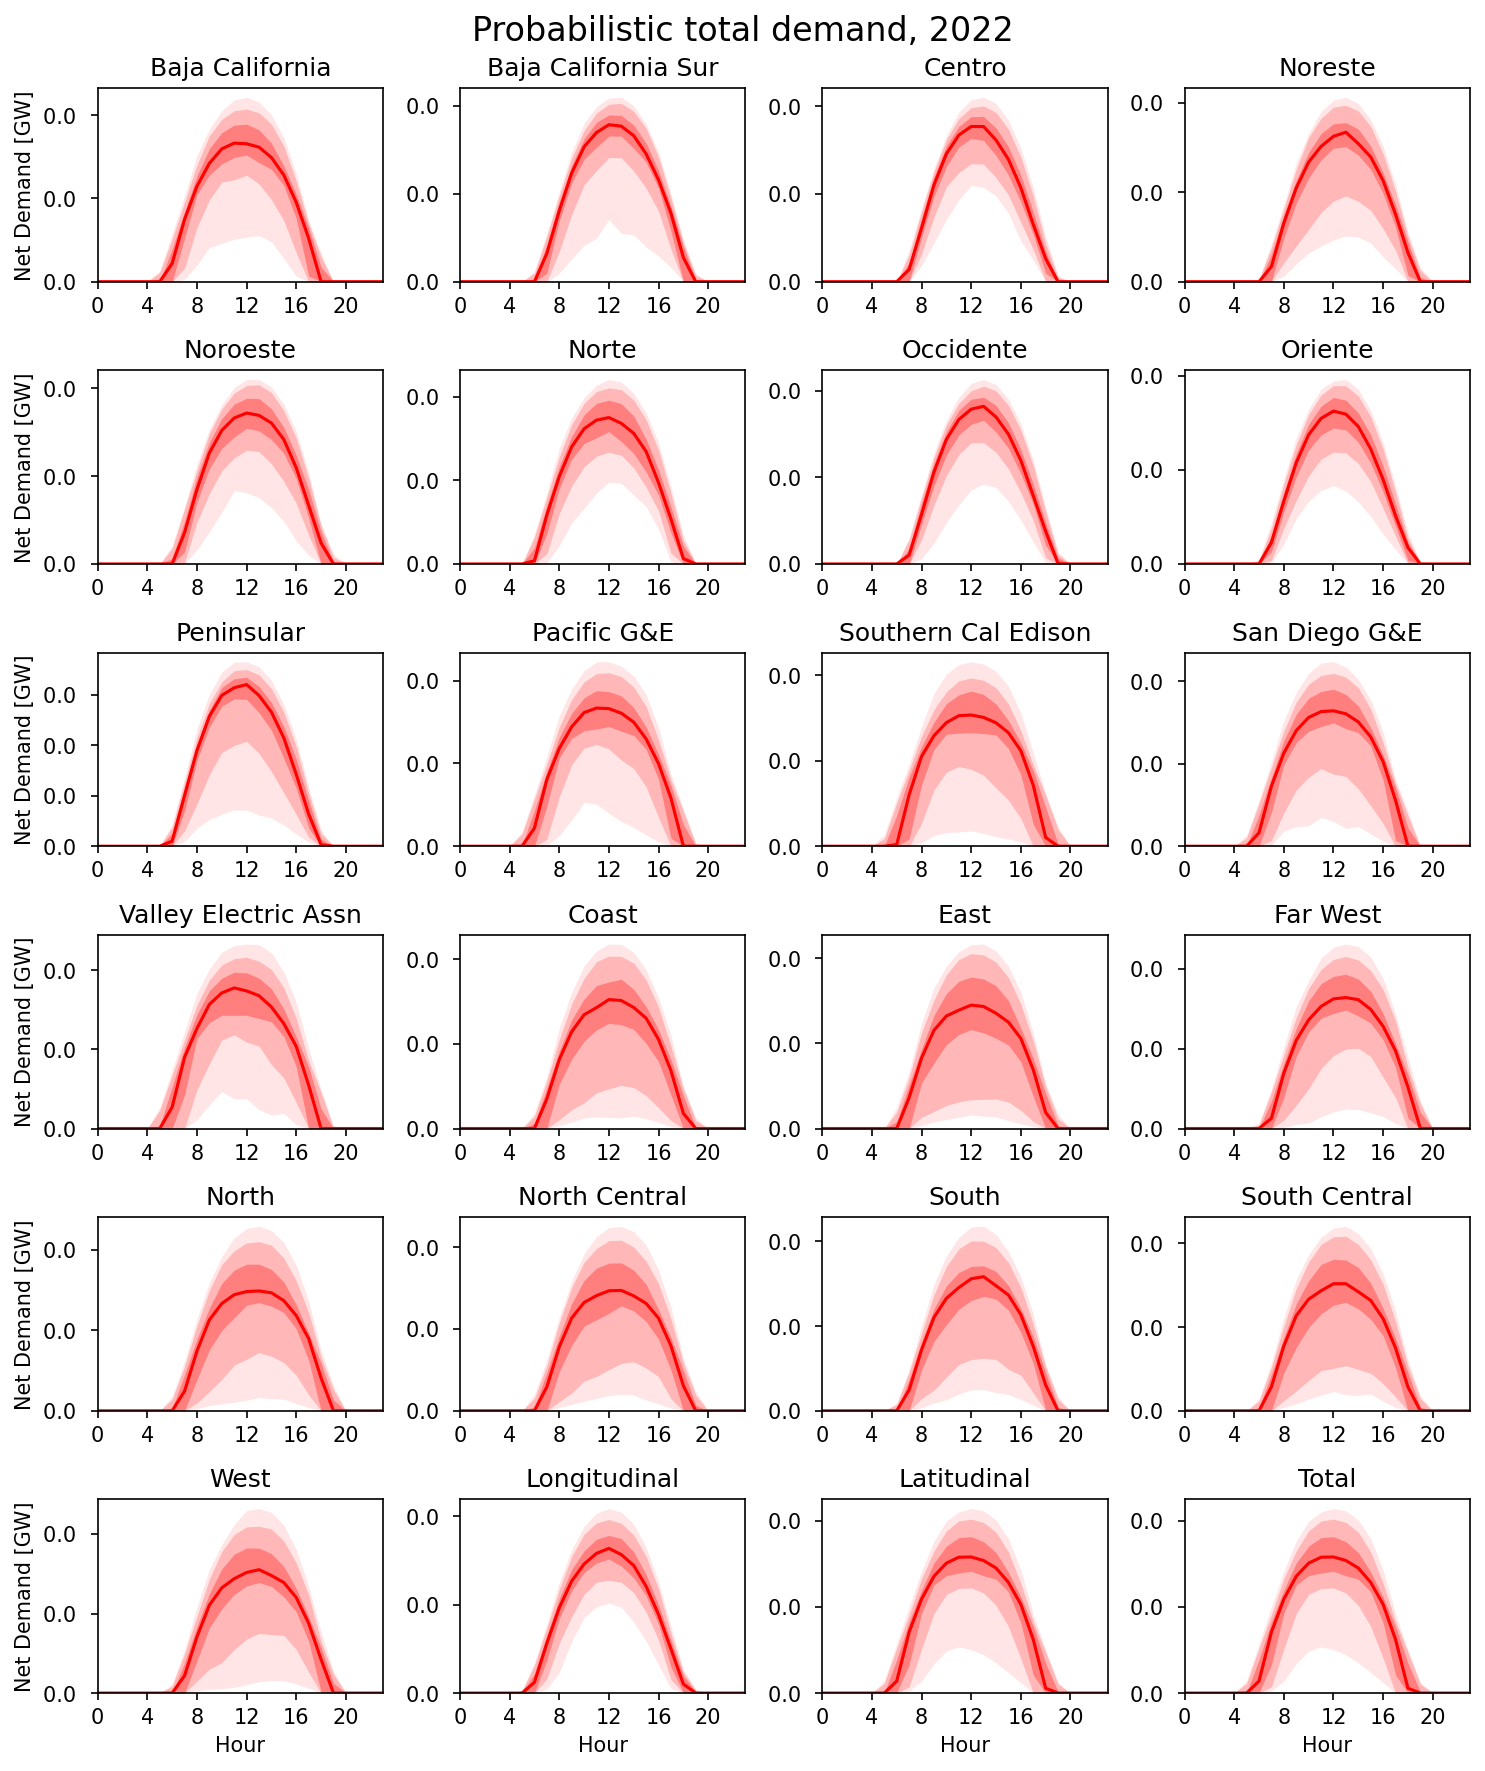

In [64]:
# Gráfica de demanda total

# Incializamos gráfica
fig, axes = plt.subplots(6, 4)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(10, 12)
fig.set_dpi(150) 

ds_c["hour"] = ds_c["time"].dt.hour.copy()
ds_c["dayofyear"] = ds_c["time"].dt.dayofyear.copy()

for i, c in enumerate( ds_c["REGION"].values ):
    reg = NAME_REGION_r(c)
    df = ds_c.sel({"REGION": c}).drop_vars("REGION").to_dataframe()
    if c in [22, 23, 24]: df = df[df.index.dayofyear.isin(range(2, 365))]

    # Procesamos datos
    a = df[ ["hour", "dayofyear", "bifacial_south_P_mp_total"]
        ].reset_index(drop = True).pivot( index = "hour",
        columns = "dayofyear", values = "bifacial_south_P_mp_total" ) / 1000
    b = a.quantile( [0, 0.005, 0.05, 0.25,
        0.5, 0.75, 0.95, 0.995, 1], axis = 1 ).T

    # Graficamos
    axes[i].fill_between(b.index, b[1], b[0],
        color = "red", alpha = 0.1, linewidth = 0)
    #axes[i].fill_between(b.index, b[0.995], b[0.005],
    #  color = "red", alpha = 0.1, linewidth = 0)
    axes[i].fill_between(b.index, b[0.95], b[0.05],
        color = "red", alpha = 0.2, linewidth = 0)
    axes[i].fill_between(b.index, b[0.75], b[0.25],
        color = "red", alpha = 0.3, linewidth = 0)
    axes[i].plot(b.index, b[0.5], color = "red")
    #axes[i].plot( a.index,
    #   a[a.min().sort_values().index[0]], color = "darkred" )

    # Formato de gráfica
    #axes[i].legend( ["Minimum-maximum envelope", "5-95% percentile",
    #    "25-75% percentile", "Median", "Day with minimum demand"] )
    axes[i].set_xlim(0, 23)
    axes[i].set_ylim(0)
    axes[i].xaxis.set_major_locator(plt.MultipleLocator(4))
    axes[i].yaxis.set_major_formatter(StrMethodFormatter("{x:<4.1f}"))
    if i%4 == 0: axes[i].set_ylabel("Net Demand [GW]")
    axes[i].set_title(reg)

# Formato de toda la gráfica
for i in [-4, -3, -2, -1]: axes[i].set_xlabel("Hour")
fig.suptitle(f"Probabilistic total demand, 2022",
    fontsize = 16)
fig.tight_layout()
plt.show()

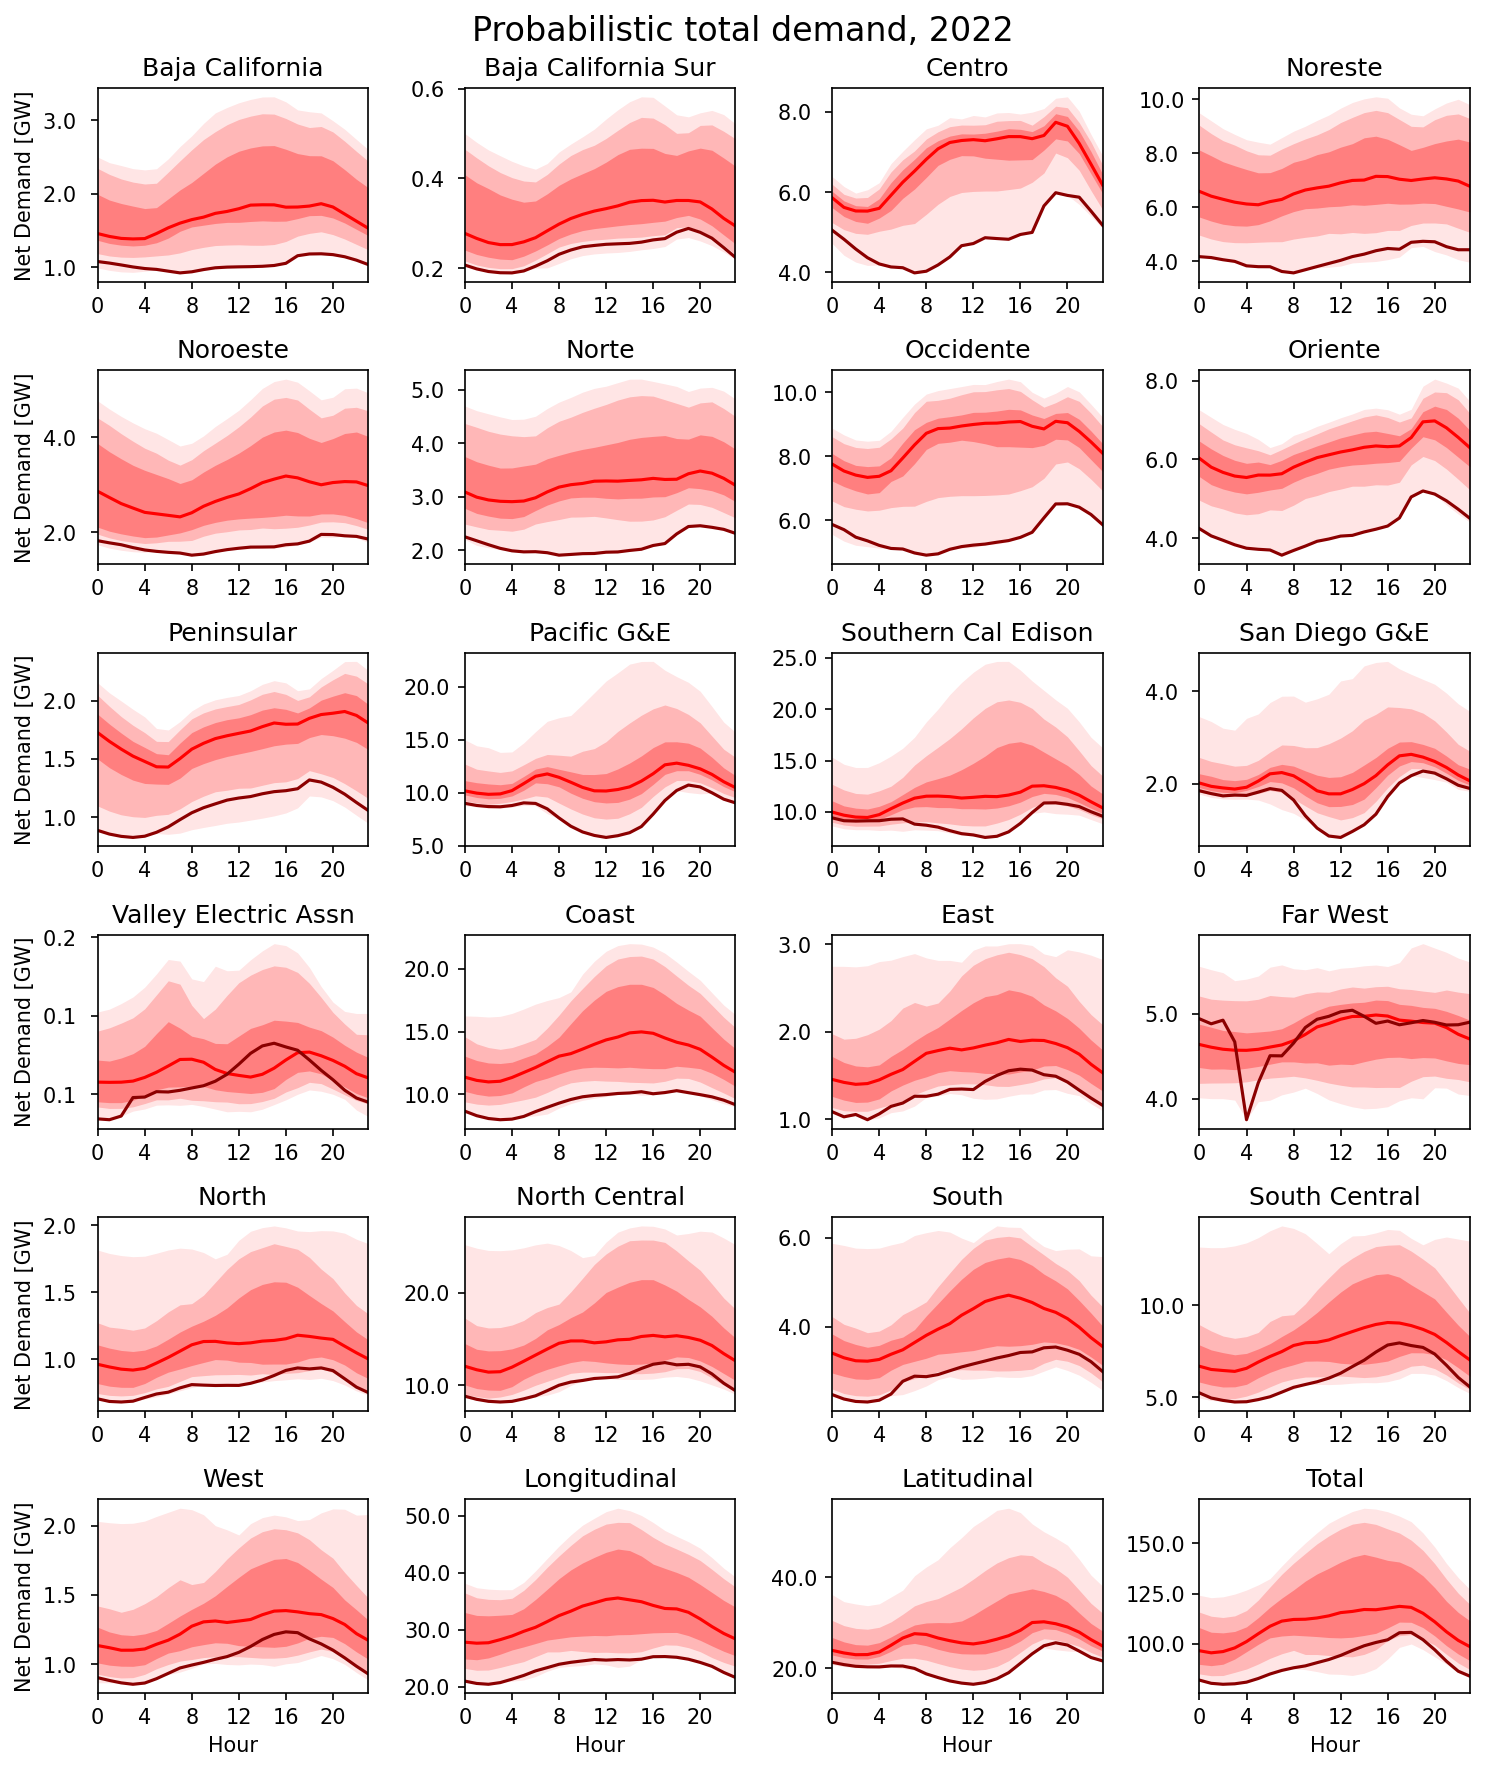

In [65]:
# Gráfica de demanda total

# Incializamos gráfica
fig, axes = plt.subplots(6, 4)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(10, 12)
fig.set_dpi(150) 

for i, c in enumerate( ds_d["REGION"].values ):
    reg = NAME_REGION_r(c)
    df = ds_d.sel({"REGION": c}).drop_vars("REGION").to_dataframe()
    if c in [22, 23, 24]: df = df[df.index.dayofyear.isin(range(2, 365))]

    # Procesamos datos
    a = df[ ["hour", "dayofyear", "Demand"]
        ].reset_index(drop = True).pivot( index = "hour",
        columns = "dayofyear", values = "Demand" ) / 1000
    b = a.quantile( [0, 0.005, 0.05, 0.25,
        0.5, 0.75, 0.95, 0.995, 1], axis = 1 ).T

    # Graficamos
    axes[i].fill_between(b.index, b[1], b[0],
        color = "red", alpha = 0.1, linewidth = 0)
    #axes[i].fill_between(b.index, b[0.995], b[0.005],
    #  color = "red", alpha = 0.1, linewidth = 0)
    axes[i].fill_between(b.index, b[0.95], b[0.05],
        color = "red", alpha = 0.2, linewidth = 0)
    axes[i].fill_between(b.index, b[0.75], b[0.25],
        color = "red", alpha = 0.3, linewidth = 0)
    axes[i].plot(b.index, b[0.5], color = "red")
    axes[i].plot( a.index,
       a[a.min().sort_values().index[0]], color = "darkred" )

    # Formato de gráfica
    #axes[i].legend( ["Minimum-maximum envelope", "5-95% percentile",
    #    "25-75% percentile", "Median", "Day with minimum demand"] )
    axes[i].set_xlim(0, 23)
    #axes[i].set_ylim(0, 20000)
    axes[i].xaxis.set_major_locator(plt.MultipleLocator(4))
    axes[i].yaxis.set_major_formatter(StrMethodFormatter("{x:<4.1f}"))
    if i%4 == 0: axes[i].set_ylabel("Net Demand [GW]")
    axes[i].set_title(reg)

# Formato de toda la gráfica
for i in [-4, -3, -2, -1]: axes[i].set_xlabel("Hour")
fig.suptitle(f"Probabilistic total demand, 2022",
    fontsize = 16)
fig.tight_layout()
plt.show()

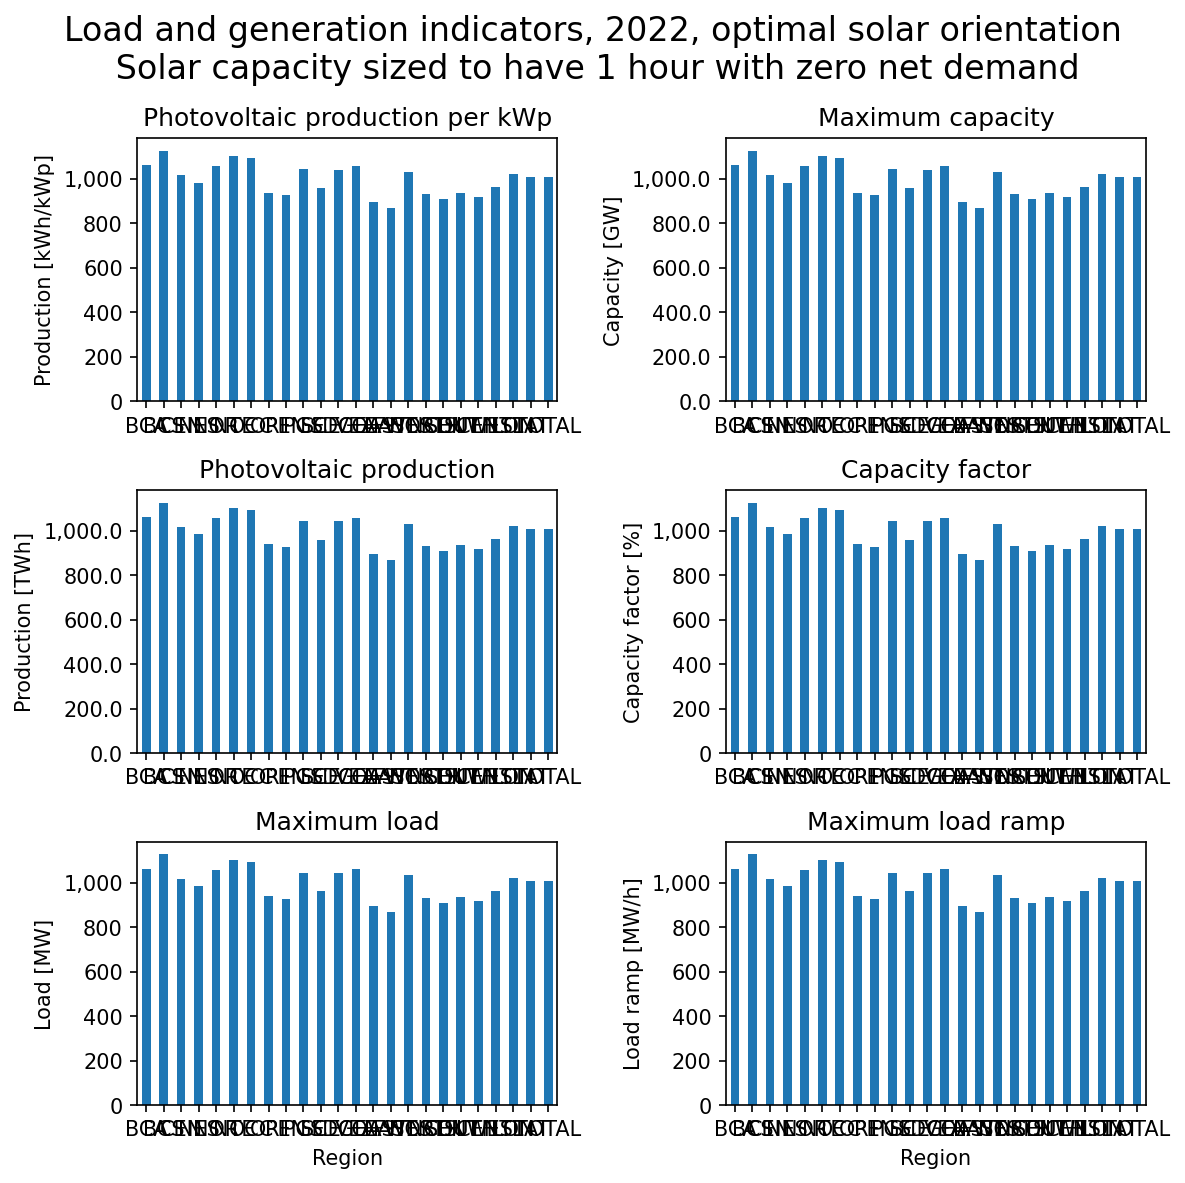

In [66]:
# Comparamos cada variable para las distintas regiones

# Escogemos la configuración ideal para cada región
conf_i = max_score.apply(lambda x: names_dn.index(x))

# Incializamos gráfica
fig, axes = plt.subplots(3, 2)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Photovoltaic production per kWp
df_r_2 = pd.DataFrame(index = df_r.index, columns = ["Data"])
for c in df_r_2.index.values:
    df_r_2.loc[c] = df_r.loc[c, prod_n_sum_i[24 + conf_i[NUM_REGION(c)]]]
df_r_2.plot.bar( ax = axes[0], rot = 0, legend = False )
axes[0].set_title("Photovoltaic production per kWp")
axes[0].set_xlabel("")
axes[0].set_ylabel("Production [kWh/kWp]")
axes[0].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
#axes[0].set_ylim(11, 12)

# Maximum capacity
df_r_2 = pd.DataFrame(index = df_r.index, columns = ["Data"])
for c in df_r_2.index.values:
    df_r_2.loc[c] = df_r.loc[c, prod_n_sum_i[24 + conf_i[NUM_REGION(c)]]]
df_r_2.plot.bar( ax = axes[1], rot = 0, legend = False )
axes[1].set_title("Maximum capacity")
axes[1].set_xlabel("")
axes[1].set_ylabel("Capacity [GW]")
axes[1].yaxis.set_major_formatter(StrMethodFormatter("{x:,.1f}"))
#axes[1].set_ylim(11, 12)

# Photovoltaic production
df_r_2 = pd.DataFrame(index = df_r.index, columns = ["Data"])
for c in df_r_2.index.values:
    df_r_2.loc[c] = df_r.loc[c, prod_n_sum_i[24 + conf_i[NUM_REGION(c)]]]
df_r_2.plot.bar( ax = axes[2], rot = 0, legend = False )
axes[2].set_title("Photovoltaic production")
axes[2].set_xlabel("")
axes[2].set_ylabel("Production [TWh]")
axes[2].yaxis.set_major_formatter(StrMethodFormatter("{x:,.1f}"))
#axes[2].set_ylim(7800, 8400)

# Capacity factor
df_r_2 = pd.DataFrame(index = df_r.index, columns = ["Data"])
for c in df_r_2.index.values:
    df_r_2.loc[c] = df_r.loc[c, prod_n_sum_i[24 + conf_i[NUM_REGION(c)]]]
df_r_2.plot.bar( ax = axes[3], rot = 0, legend = False )
axes[3].set_title("Capacity factor")
axes[3].set_xlabel("")
axes[3].set_ylabel("Capacity factor [%]")
axes[3].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
#axes[3].set_ylim(7800, 8400)

# Maximum load
df_r_2 = pd.DataFrame(index = df_r.index, columns = ["Data"])
for c in df_r_2.index.values:
    df_r_2.loc[c] = df_r.loc[c, prod_n_sum_i[24 + conf_i[NUM_REGION(c)]]]
df_r_2.plot.bar( ax = axes[4], rot = 0, legend = False )
axes[4].set_title("Maximum load")
axes[4].set_xlabel("Region")
axes[4].set_ylabel("Load [MW]")
axes[4].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
#axes[4].set_ylim(7800, 8400)

# Maximum load ramp
df_r_2 = pd.DataFrame(index = df_r.index, columns = ["Data"])
for c in df_r_2.index.values:
    df_r_2.loc[c] = df_r.loc[c, prod_n_sum_i[24 + conf_i[NUM_REGION(c)]]]
df_r_2.plot.bar( ax = axes[5], rot = 0, legend = False )
axes[5].set_title("Maximum load ramp")
axes[5].set_xlabel("Region")
axes[5].set_ylabel("Load ramp [MW/h]")
axes[5].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
#axes[5].set_ylim(2500, 3100)

# Formato de toda la gráfica
fig.suptitle("Load and generation indicators, 2022, optimal solar orientation"
    + "\n Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

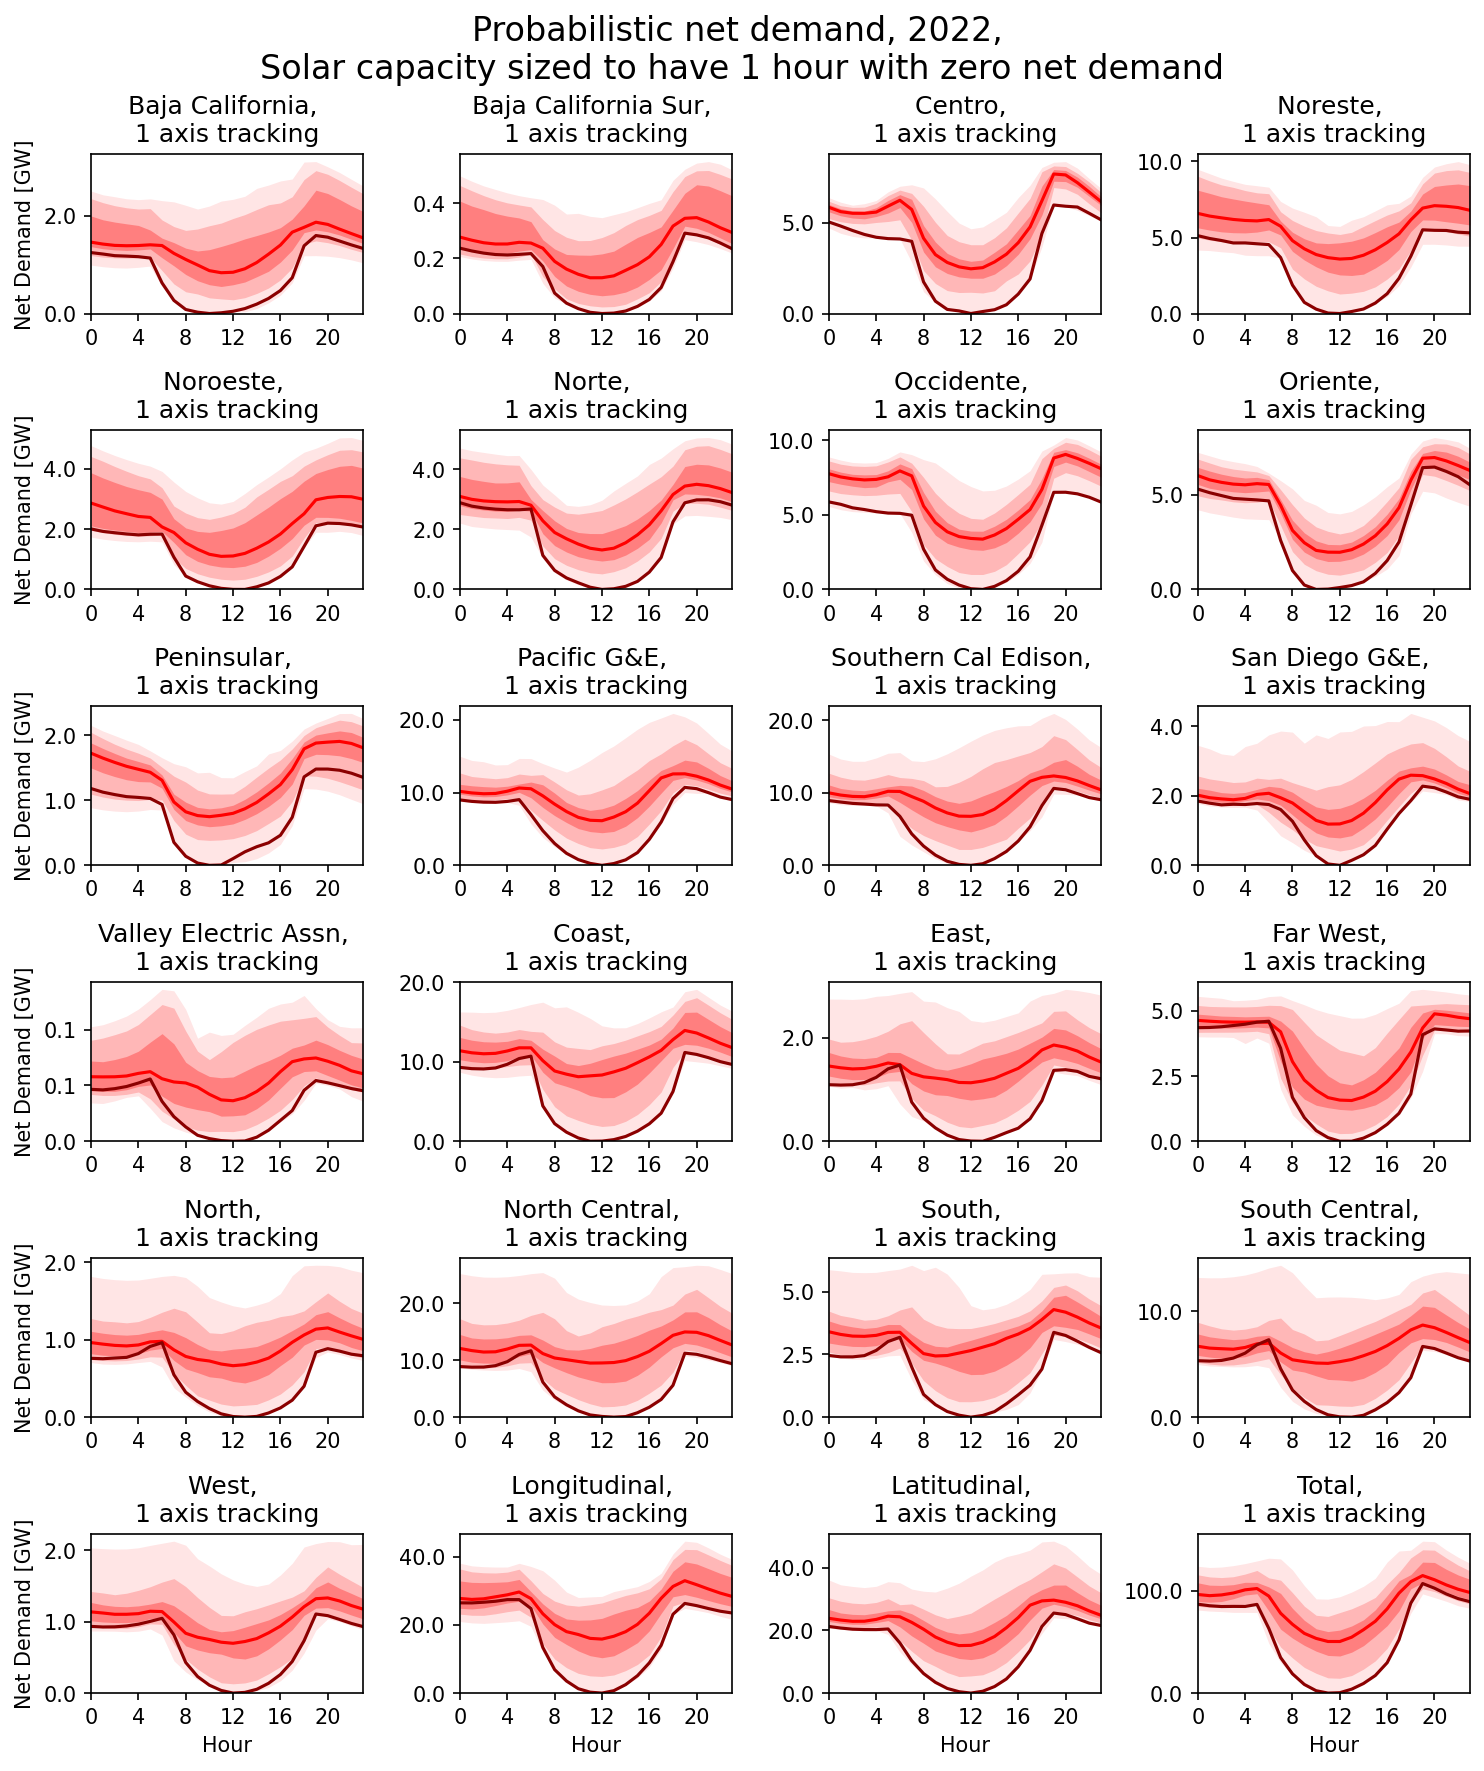

In [67]:
# Gráfica de demanda neta

# Incializamos gráfica
fig, axes = plt.subplots(6, 4)
axes = fig.axes
fig.set_facecolor("w")
fig.set_size_inches(10, 12)
fig.set_dpi(150) 

n = 24
# Iteramos para cada gráfica
for i, ax in enumerate(axes):
    # Procesamos datos
    c = ds_c["REGION"].values[i]
    a = ds_c.sel({"REGION": c}).drop_vars("REGION")[ [ "hour", "dayofyear",
        track_net_demand[n + conf_i[c]] ] ].to_dataframe()
    a[track_net_demand[n + conf_i[c]]] /= 1000
    a = a.reset_index(drop = True).pivot( index = "hour",
        columns = "dayofyear", values = track_net_demand[n + conf_i[c]] )
    b = a.quantile( [0, 0.005, 0.05, 0.25,
        0.5, 0.75, 0.95, 0.995, 1], axis = 1) .T

    # Graficamos
    ax.fill_between(b.index, b[1], b[0],
        color = "red", alpha = 0.1, linewidth = 0)
    #ax.fill_between(b.index, b[0.995], b[0.005],
    #    color = "red", alpha = 0.1, linewidth = 0)
    ax.fill_between(b.index, b[0.95], b[0.05],
        color = "red", alpha = 0.2, linewidth = 0)
    ax.fill_between(b.index, b[0.75], b[0.25],
        color = "red", alpha = 0.3, linewidth = 0)
    ax.plot(b.index, b[0.5], color = "red")
    ax.plot(a.index, a[ a.min().sort_values().index[0] ], color = "darkred")

    ax.set_title(f"{NAME_REGION_r(c)}, \n{names_dn[conf_i[c]]}")
    ax.set_xlim(0, 23)
    ax.set_ylim(0)
    #ax.set_ylim(0, 10000)
    ax.xaxis.set_major_locator(plt.MultipleLocator(4))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.1f}"))
    if i%4 == 0: ax.set_ylabel("Net Demand [GW]")
    if len(axes) - i <= 4: ax.set_xlabel("Hour")

# Formato de toda la gráfica
fig.suptitle(f"Probabilistic net demand, 2022, \n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

# Resumen por región

In [86]:
# Escogemos los datos de una región
c = 24
reg = NAME_REGION_r(c)
df = ds_c.sel({"REGION": c}).drop_vars("REGION").to_dataframe()

# Resultados de producción fotovoltaica
pd.options.display.float_format = "{:,.0f} kWh/kWp".format

# Non-weighted
print(f"Photovoltaic production, non-weighted, {reg}")
a = df[prod_n_sum].iloc[0]
a.index = prod_n
print(a.sort_values(ascending = False).to_string())

# Distributed
print()
print(f"Photovoltaic production, distributed, {reg}")
a = df[prod_n_dist_sum].iloc[0]
a.index = prod_n
print(a.sort_values(ascending = False).to_string())

# Solar parks
print()
print(f"Photovoltaic production, solar parks, {reg}")
a = df[prod_n_centr_sum].iloc[0]
a.index = prod_n
print(a.sort_values(ascending = False).to_string())

# Photovoltaic production
print()
print(f"Photovoltaic production, total, {reg}")
a = df[prod_n_total_sum].iloc[0]
a.index = prod_n
print(a.sort_values(ascending = False).to_string())


Photovoltaic production, non-weighted, Total
2_track_P_mp                  2,173 kWh/kWp
1_track_P_mp                  2,063 kWh/kWp
bifacial_south_P_mp           1,944 kWh/kWp
south_no_track_P_mp           1,764 kWh/kWp
east_no_track_P_mp            1,683 kWh/kWp
west_no_track_P_mp            1,616 kWh/kWp
bifacial_vertical_east_P_mp   1,358 kWh/kWp
bifacial_vertical_west_P_mp   1,315 kWh/kWp

Photovoltaic production, distributed, Total
south_no_track_P_mp           1,763 kWh/kWp
west_no_track_P_mp            1,763 kWh/kWp
east_no_track_P_mp            1,763 kWh/kWp
1_track_P_mp                  1,763 kWh/kWp
2_track_P_mp                  1,763 kWh/kWp
bifacial_vertical_west_P_mp   1,763 kWh/kWp
bifacial_vertical_east_P_mp   1,763 kWh/kWp
bifacial_south_P_mp           1,763 kWh/kWp

Photovoltaic production, solar parks, Total
2_track_P_mp                  2,173 kWh/kWp
1_track_P_mp                  2,063 kWh/kWp
bifacial_south_P_mp           1,944 kWh/kWp
south_no_track_P_mp          

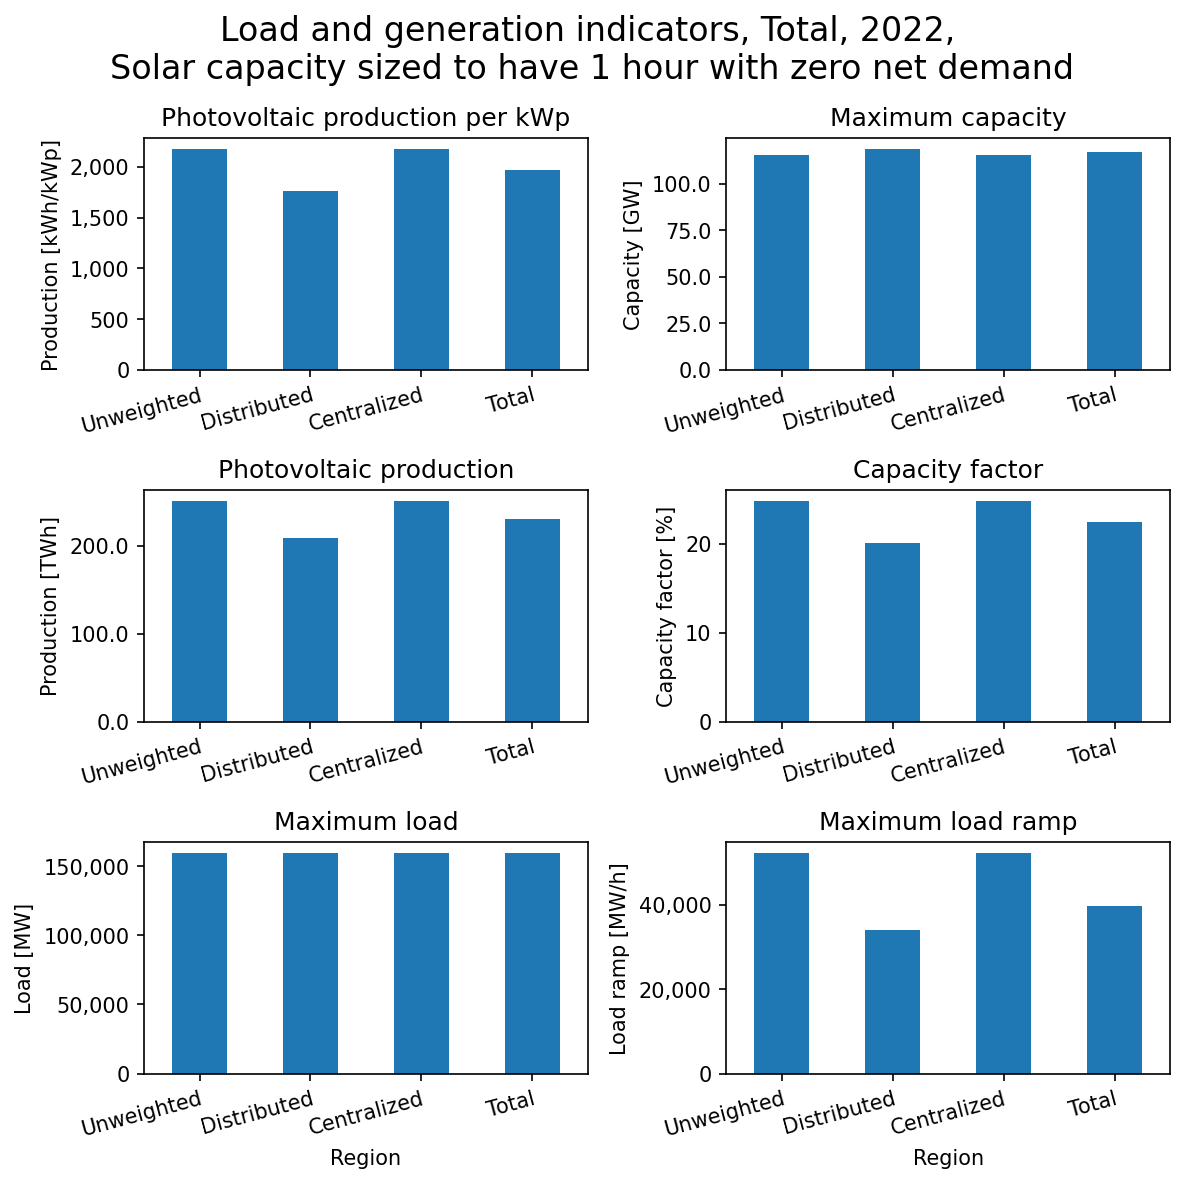

In [87]:
# Comparamos cada variable para los distintos tipos de producción solar

# Incializamos gráfica
fig, axes = plt.subplots(3, 2)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Photovoltaic production per kWp
a = df[prod_n_sum_i[4::8]].iloc[0].plot.bar( ax = axes[0] )
axes[0].set_title("Photovoltaic production per kWp")
axes[0].set_xlabel("")
axes[0].set_ylabel("Production [kWh/kWp]")
axes[0].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
axes[0].set_xticklabels(solar_cat, rotation = 15,
    ha = "right", rotation_mode = "anchor")
#axes[0].set_ylim(11, 12)

# Maximum capacity
a = df[prod_n_cap[4::8]].iloc[0].plot.bar( ax = axes[1] )
axes[1].set_title("Maximum capacity")
axes[1].set_xlabel("")
axes[1].set_ylabel("Capacity [GW]")
axes[1].yaxis.set_major_formatter(StrMethodFormatter("{x:,.1f}"))
axes[1].set_xticklabels(solar_cat, rotation = 15,
    ha = "right", rotation_mode = "anchor")
#axes[1].set_ylim(11, 12)

# Photovoltaic production
a = df[ener[4::8]].iloc[0].plot.bar( ax = axes[2] )
axes[2].set_title("Photovoltaic production")
axes[2].set_xlabel("")
axes[2].set_ylabel("Production [TWh]")
axes[2].yaxis.set_major_formatter(StrMethodFormatter("{x:,.1f}"))
axes[2].set_xticklabels(solar_cat, rotation = 15,
    ha = "right", rotation_mode = "anchor")
#axes[2].set_ylim(7800, 8400)

# Capacity factor
a = df[cap_f[4::8]].iloc[0].plot.bar( ax = axes[3] )
axes[3].set_title("Capacity factor")
axes[3].set_xlabel("")
axes[3].set_ylabel("Capacity factor [%]")
axes[3].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
axes[3].set_xticklabels(solar_cat, rotation = 15,
    ha = "right", rotation_mode = "anchor")
#axes[3].set_ylim(7800, 8400)

# Maximum load
a = df[track_net_demand_max[4::8]].iloc[0].plot.bar( ax = axes[4] )
axes[4].set_title("Maximum load")
axes[4].set_xlabel("Production weighting")
axes[4].set_ylabel("Load [MW]")
axes[4].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
axes[4].set_xticklabels(solar_cat, rotation = 15,
    ha = "right", rotation_mode = "anchor")
#axes[4].set_ylim(7800, 8400)

# "Maximum load ramp"
a = df[track_net_demand_dt_max[4::8]].iloc[0].plot.bar( ax = axes[5] )
axes[5].set_title("Maximum load ramp")
axes[5].set_xlabel("Region")
axes[5].set_ylabel("Load ramp [MW/h]")
axes[5].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
axes[5].set_xticklabels(solar_cat, rotation = 15,
    ha = "right", rotation_mode = "anchor")
#axes[5].set_ylim(2500, 3100)

# Formato de toda la gráfica
fig.suptitle(f"Load and generation indicators, {reg}, 2022, \n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_1354/3404005340.py:35: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend( ["_", "5-95% percentile"],
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_1354/3404005340.py:38: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend( ["_", "_", "25-75% percentile"],
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_1354/3404005340.py:41: MatplotlibDeprecationWarning: An artist whose label starts with an underscor

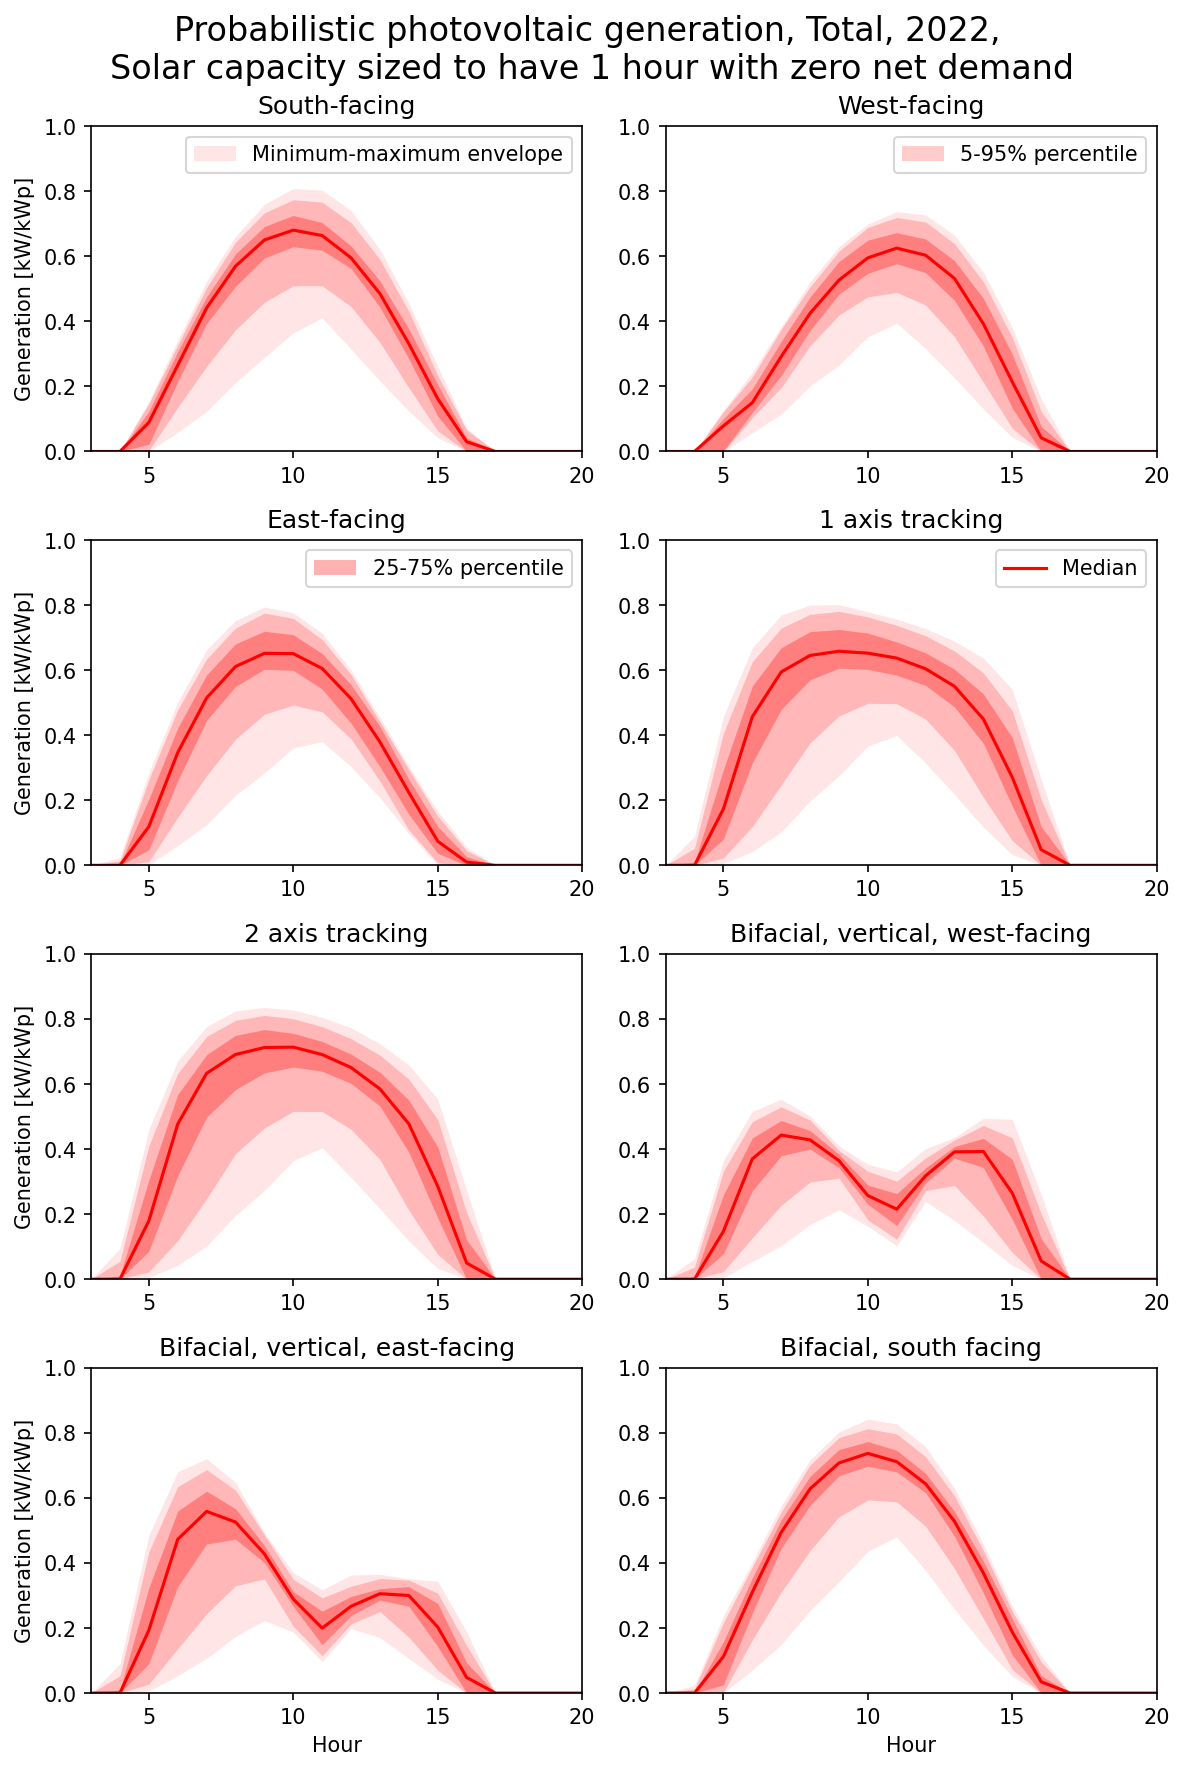

In [88]:
# Gráfica de producción fotovoltaica

# Incializamos gráfica
fig, axes = plt.subplots(4, 2)
axes = fig.axes
fig.set_facecolor("w")
fig.set_size_inches(8, 12)
fig.set_dpi(150) 

# Iteramos para cada gráfica
for i, ax in enumerate(axes):
    # Procesamos los datos
    a = df[ ["hour", "dayofyear", prod_n[i]]
        ].reset_index(drop = True).pivot( index = "hour",
        columns = "dayofyear", values = prod_n[i] )
    b = a.quantile( [0, 0.005, 0.05, 0.25,
        0.5, 0.75, 0.95, 0.995, 1], axis = 1 ).T

    # Graficamos
    ax.fill_between(b.index, b[1], b[0],
        color = "red", alpha = 0.1, linewidth = 0)
    #ax.fill_between(b.index, b[0.995], b[0.005],
    #    color = "red", alpha = 0.1, linewidth = 0)
    ax.fill_between(b.index, b[0.95], b[0.05],
        color = "red", alpha = 0.2, linewidth = 0)
    ax.fill_between(b.index, b[0.75], b[0.25],
        color = "red", alpha = 0.3, linewidth = 0)
    ax.plot(b.index, b[0.5], color = "red")

    # Formato de gráfica
    if   i == 0:
        ax.legend( ["Minimum-maximum envelope"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 1:
        ax.legend( ["_", "5-95% percentile"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 2:
        ax.legend( ["_", "_", "25-75% percentile"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 3:
        ax.legend( ["_", "_", "_", "Median"],
            prop = { "size": 10 }, ncol = 2 )
    ax.set_title(names_dn[i])
    ax.set_xlim(3, 20)
    ax.set_ylim(0, 1)
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.1f}"))
    if i%2 == 0: ax.set_ylabel("Generation [kW/kWp]")
    if len(axes) - i <= 2: ax.set_xlabel("Hour")

# Formato de toda la gráfica
fig.suptitle(f"Probabilistic photovoltaic generation, {reg}, 2022, \n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

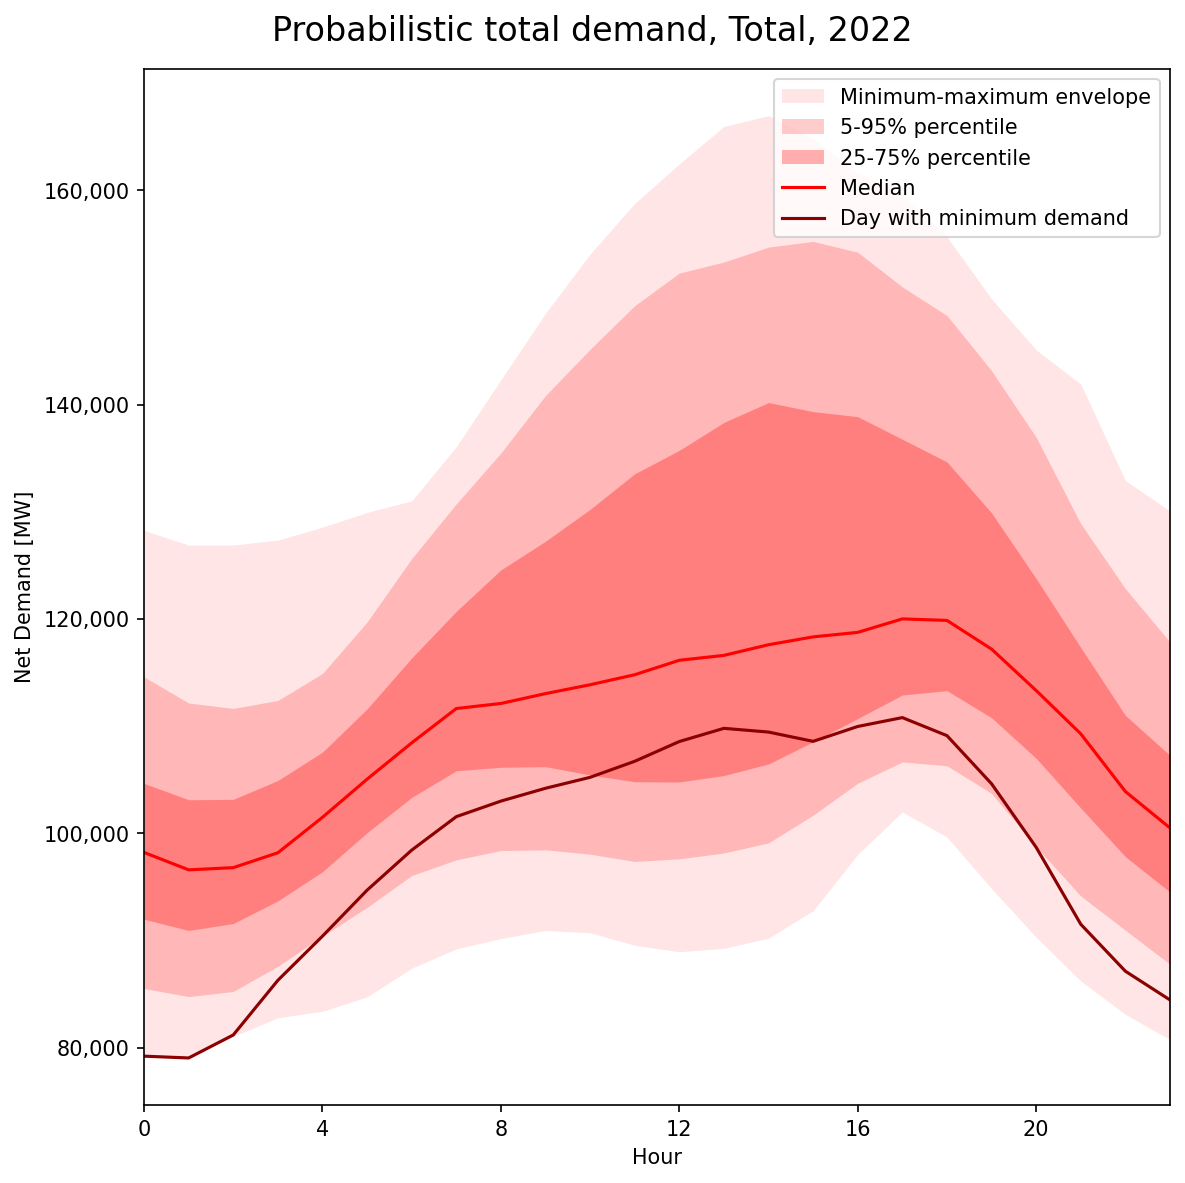

In [100]:
# Gráfica de demanda total

# Incializamos gráfica
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Procesamos datos
a = df[ ["hour", "dayofyear", "Demand"]
    ].reset_index(drop = True).pivot( index = "hour",
    columns = "dayofyear", values = "Demand" )
if c in [22, 23, 24]: a = a.drop(columns = [1, 365])
b = a.quantile([0, 0.005, 0.05, 0.25, 0.5, 0.75, 0.95, 0.995, 1], axis = 1).T

# Graficamos
ax.fill_between(b.index, b[1], b[0],
    color = "red", alpha = 0.1, linewidth = 0)
#ax.fill_between(b.index, b[0.995], b[0.005],
#    color = "red", alpha = 0.1, linewidth = 0)
ax.fill_between(b.index, b[0.95], b[0.05],
    color = "red", alpha = 0.2, linewidth = 0)
ax.fill_between(b.index, b[0.75], b[0.25],
    color = "red", alpha = 0.3, linewidth = 0)
ax.plot(b.index, b[0.5], color = "red")
ax.plot(a.index, a[ a.min().sort_values().index[0] ], color = "darkred")

# Formato de gráfica
ax.legend( ["Minimum-maximum envelope", "5-95% percentile",
    "25-75% percentile", "Median", "Day with minimum demand"] )
ax.set_xlim(0, 23)
#ax.set_ylim(3500, 8500)
ax.xaxis.set_major_locator(plt.MultipleLocator(4))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("Net Demand [MW]")
ax.set_xlabel("Hour")
fig.suptitle(f"Probabilistic total demand, {reg}, 2022",
    fontsize = 16)
fig.tight_layout()
plt.show()

In [90]:
# Resultados para cada configuración
results = [ prod_n_sum_i[-8:], prod_n_cap[-8:], ener[-8:], cap_f[-8:],
     track_net_demand_max[-8:], track_net_demand_dt_max[-8:] ]
indicators = [ "Photovoltaic production per kWp", "Maximum capacity",
    "Photovoltaic production", "Capacity factor",
    "Maximum load", "Maximum load ramp" ]
format = [ "{:,.0f} kWh/kWp".format, "{:.1f} GW".format,
           "{:,.0f} TWh".format, "{:.1f} %".format,
           "{:,.0f} MW".format, "{:,.0f} MW".format]

for i in range(len(results)):
    print(indicators[i])
    pd.options.display.float_format = format[i]
    a = df[results[i]].iloc[i]
    a.index = names_dn
    print( a.sort_values(ascending = False).to_string() )
    print()

Photovoltaic production per kWp
2 axis tracking                   1,966 kWh/kWp
1 axis tracking                   1,911 kWh/kWp
Bifacial, south facing            1,853 kWh/kWp
South-facing                      1,763 kWh/kWp
East-facing                       1,722 kWh/kWp
West-facing                       1,688 kWh/kWp
Bifacial, vertical, east-facing   1,560 kWh/kWp
Bifacial, vertical, west-facing   1,539 kWh/kWp

Maximum capacity
Bifacial, vertical, west-facing   161.6 GW
Bifacial, vertical, east-facing   145.1 GW
West-facing                       125.1 GW
East-facing                       121.1 GW
1 axis tracking                   121.0 GW
South-facing                      118.4 GW
2 axis tracking                   117.0 GW
Bifacial, south facing            115.5 GW

Photovoltaic production
Bifacial, vertical, west-facing   249 TWh
1 axis tracking                   231 TWh
2 axis tracking                   230 TWh
Bifacial, vertical, east-facing   226 TWh
Bifacial, south facing       

/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_1354/2320260857.py:36: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend( ["_", "5-95% percentile"],
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_1354/2320260857.py:39: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend( ["_", "_", "25-75% percentile"],
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_1354/2320260857.py:42: MatplotlibDeprecationWarning: An artist whose label starts with an underscor

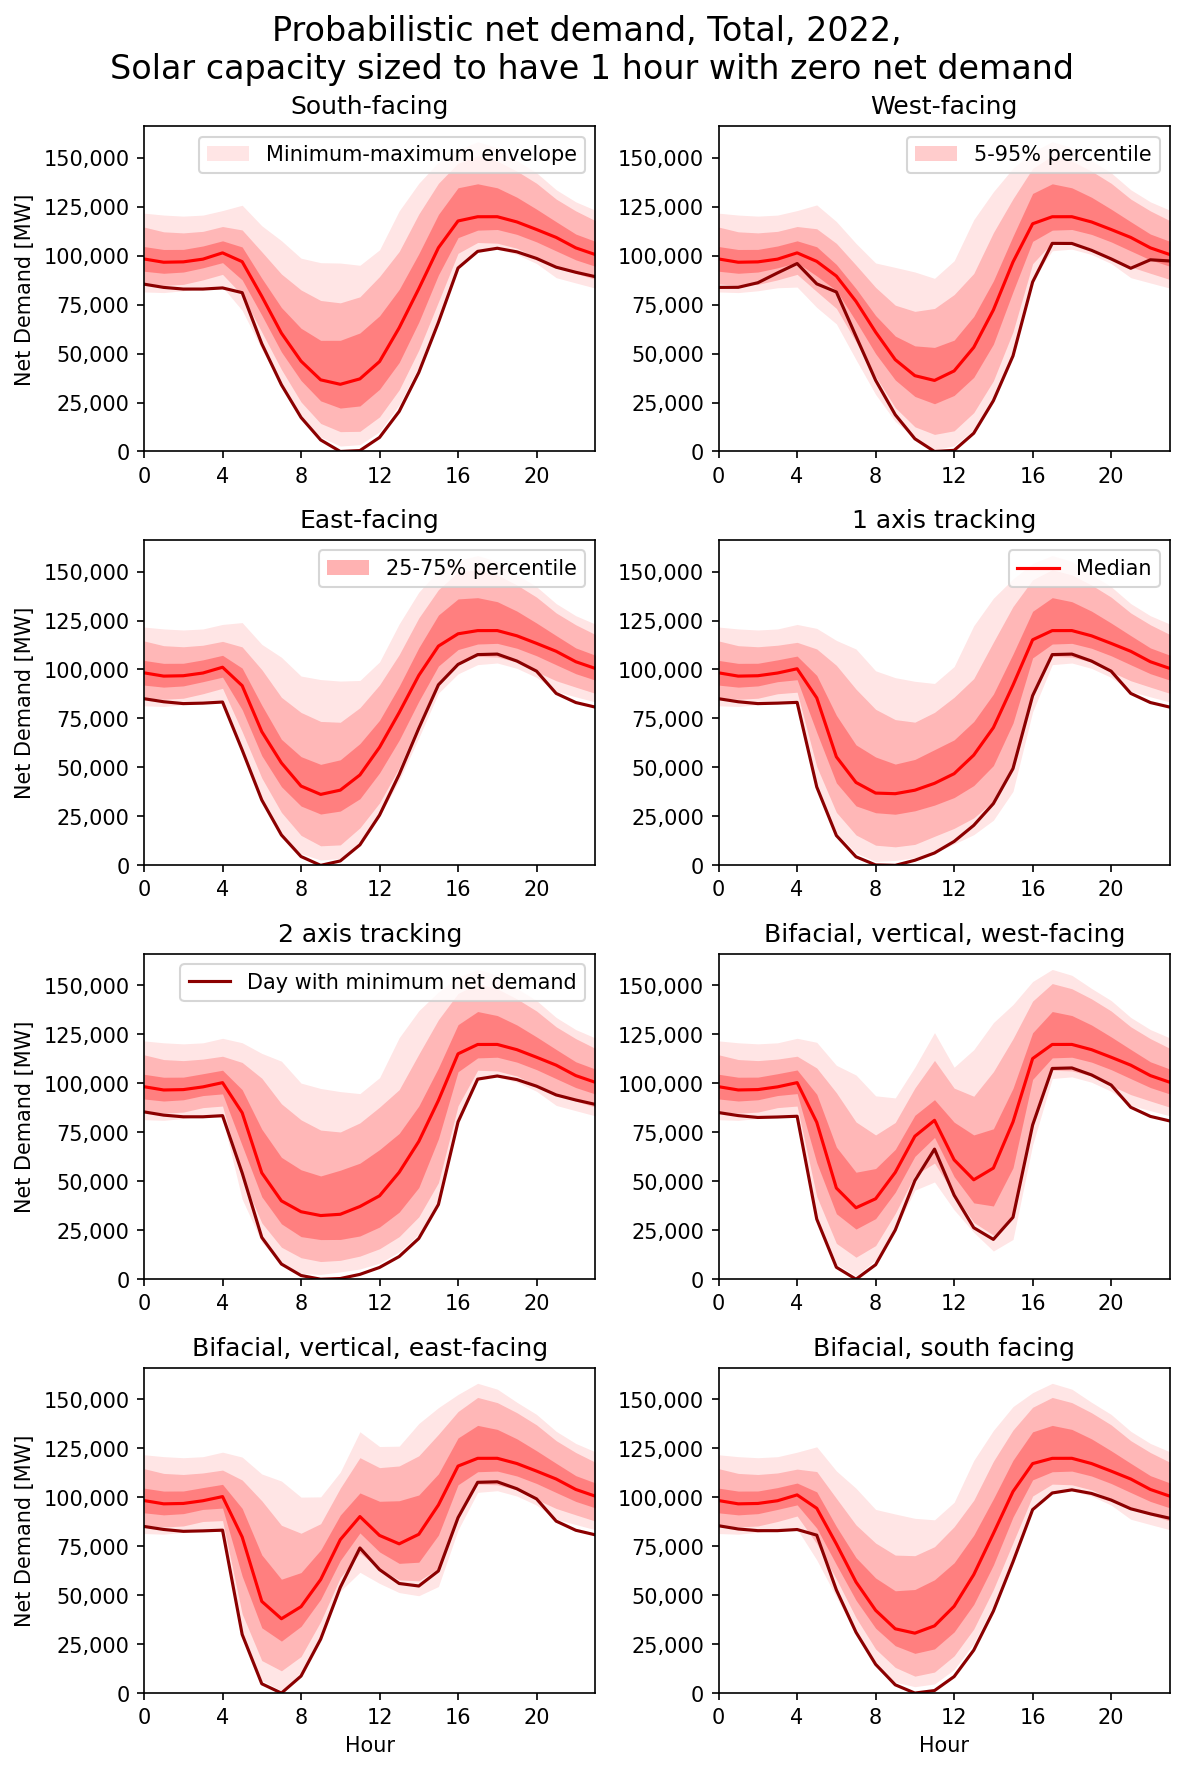

In [91]:
# Gráfica de demanda neta

# Incializamos gráfica
fig, axes = plt.subplots(4, 2)
axes = fig.axes
fig.set_facecolor("w")
fig.set_size_inches(8, 12)
fig.set_dpi(150) 

# Iteramos para cada gráfica
for i, ax in enumerate(axes):
    # Procesamos datos
    a = df[ ["hour", "dayofyear", track_net_demand[i]]
        ].reset_index(drop = True).pivot( index = "hour",
        columns = "dayofyear", values = track_net_demand[i] )
    b = a.quantile( [0, 0.005, 0.05, 0.25,
        0.5, 0.75, 0.95, 0.995, 1], axis = 1) .T

    # Graficamos
    #ax.fill_between(b.index, b[1], b[0],
    #    color = "red", alpha = 0.1, linewidth = 0)
    ax.fill_between(b.index, b[0.995], b[0.005],
        color = "red", alpha = 0.1, linewidth = 0)
    ax.fill_between(b.index, b[0.95], b[0.05],
        color = "red", alpha = 0.2, linewidth = 0)
    ax.fill_between(b.index, b[0.75], b[0.25],
        color = "red", alpha = 0.3, linewidth = 0)
    ax.plot(b.index, b[0.5], color = "red")
    ax.plot(a.index, a[ a.min().sort_values().index[0] ], color = "darkred")

    # Formato de gráfica
    if   i == 0:
        ax.legend( ["Minimum-maximum envelope"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 1:
        ax.legend( ["_", "5-95% percentile"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 2:
        ax.legend( ["_", "_", "25-75% percentile"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 3:
        ax.legend( ["_", "_", "_", "Median"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 4:
        ax.legend( ["_", "_", "_", "_", "Day with minimum net demand"],
            prop = { "size": 10 }, ncol = 2 )
    ax.set_title(names_dn[i])
    ax.set_xlim(0, 23)
    ax.set_ylim(0)
    #ax.set_ylim(0, 10000)
    ax.xaxis.set_major_locator(plt.MultipleLocator(4))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
    if i%2 == 0: ax.set_ylabel("Net Demand [MW]")
    if len(axes) - i <= 2: ax.set_xlabel("Hour")

# Formato de toda la gráfica
fig.suptitle(f"Probabilistic net demand, {reg}, 2022, \n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

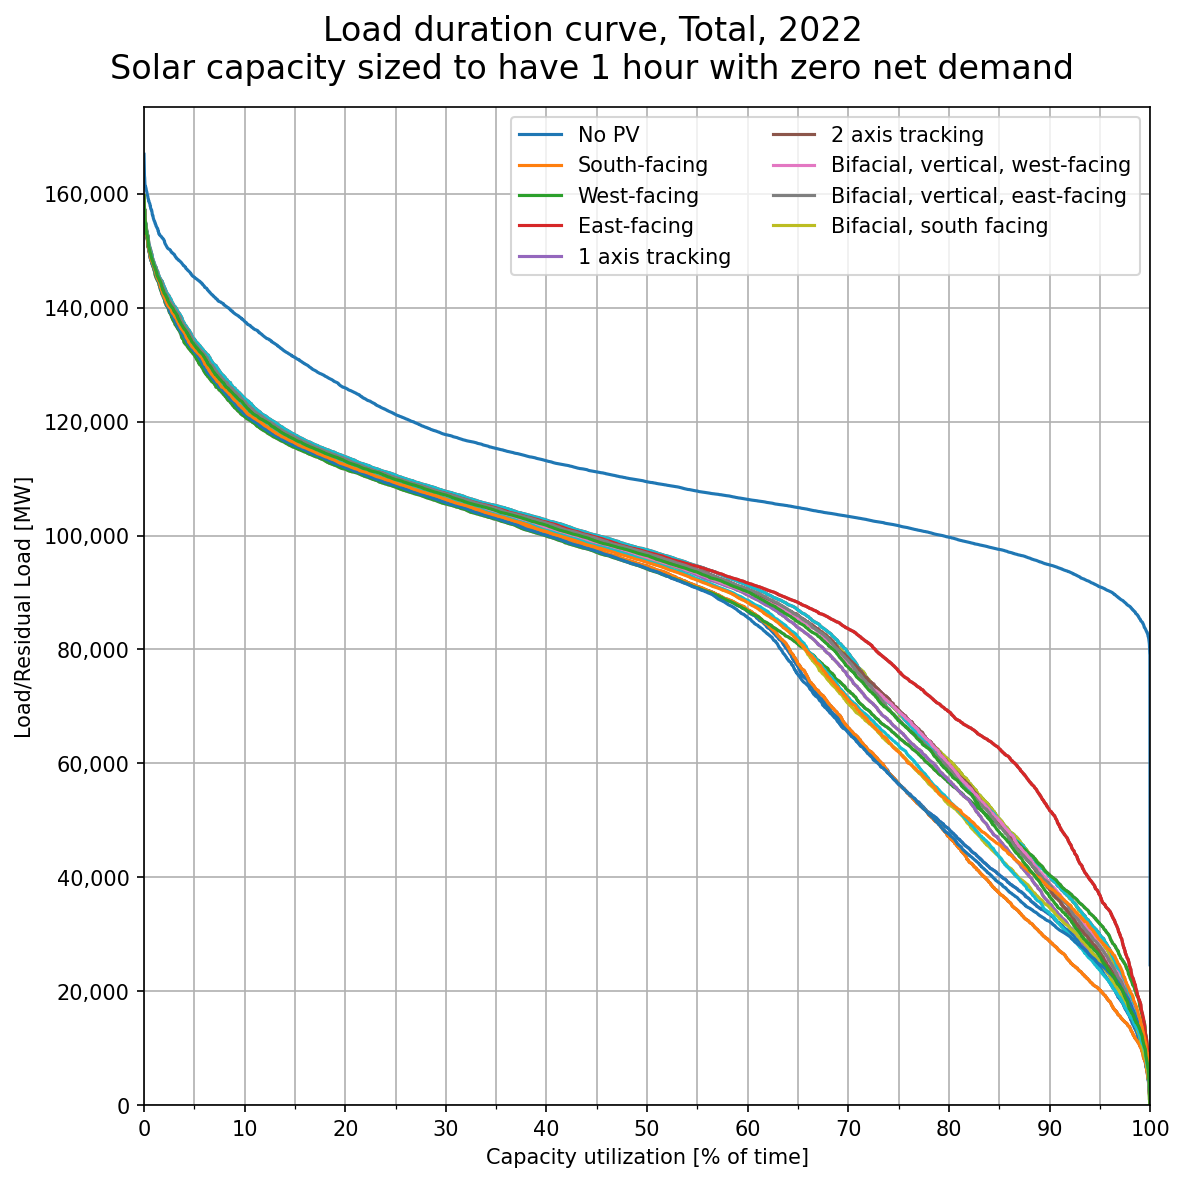

In [92]:
# Load duration curve

# Incializamos gráfica
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Iteramos para cada caso
for v in ["Demand"] + track_net_demand:
    a = df[ [v] ].sort_values( v, ascending = False ).reset_index(drop = True)
    a.index /= 2
    a.index = a.index / a.index.max() * 100
    ax.plot(a.index, a[v])

# Formato de gráfica
ax.legend( ["No PV"] + names_dn, ncol = 2 )
ax.set_xlim(0, 100)
#ax.set_ylim(0, 8500)
ax.set_ylim(0)
ax.grid("both", "both")
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
#ax.yaxis.set_major_locator(plt.MultipleLocator(1000))
#ax.yaxis.set_minor_locator(plt.MultipleLocator(500))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("Load/Residual Load [MW]")
ax.set_xlabel("Capacity utilization [% of time]")
fig.suptitle(f"Load duration curve, {reg}, 2022\n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_1354/3223343924.py:26: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axes[0].legend( ["No PV"] + names_dn[:4] + ["_"]*4, ncol = 1 )
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_1354/3223343924.py:40: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axes[1].legend( ["_"]*4 + names_dn[4:], ncol = 1 )


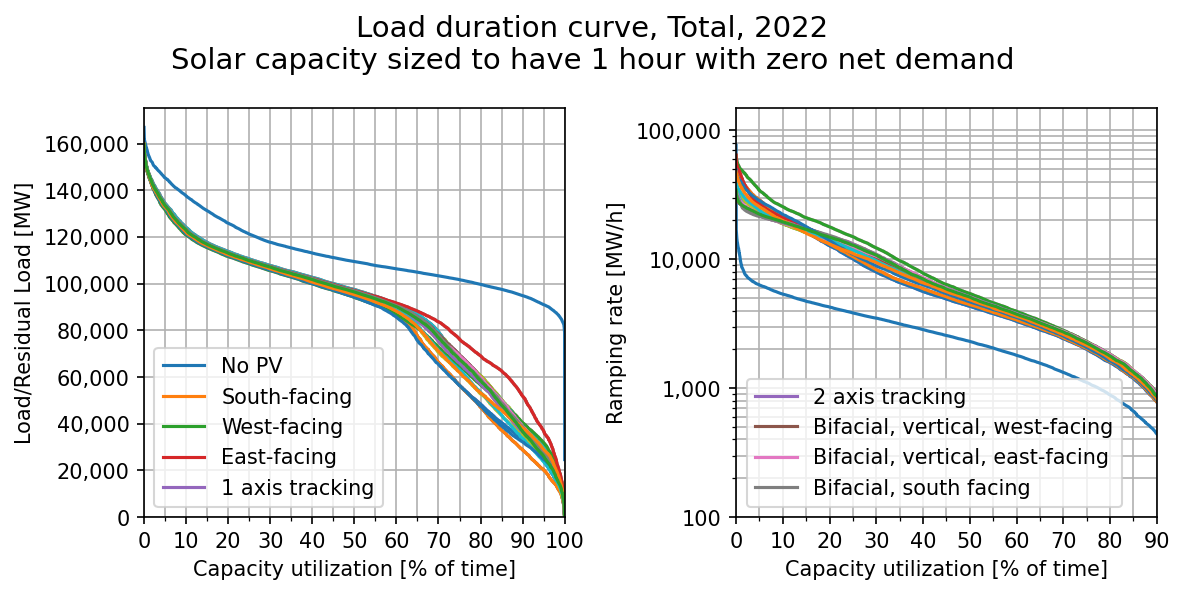

In [93]:
# Load duration curve + ramp duration curve

# Incializamos gráfica
fig, axes = plt.subplots(1, 2)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(8, 4)
fig.set_dpi(150) 

# Iteramos para cada caso
for v in ["Demand"] + track_net_demand:
    a = df[ [v] ].sort_values( v, ascending = False ).reset_index(drop = True)
    a.index /= 2
    a.index = a.index / a.index.max() * 100
    axes[0].plot(a.index, a[v])

# Iteramos para cada caso
for v in ["Demand_dt"] + track_net_demand_dt:
    a = np.abs(df[[v]]).sort_values( v,
        ascending = False ).reset_index(drop = True)
    a = a.where(a>0, 0)
    a.index = a.index / a.index.max() * 100
    axes[1].plot(a.index, a[v])

# Formato de gráfica
axes[0].legend( ["No PV"] + names_dn[:4] + ["_"]*4, ncol = 1 )
axes[0].set_xlim(0, 100)
#axes[0].set_ylim(0, 8500)
axes[0].set_ylim(0)
axes[0].grid("both", "both")
axes[0].xaxis.set_major_locator(plt.MultipleLocator(10))
axes[0].xaxis.set_minor_locator(plt.MultipleLocator(5))
#axes[0].yaxis.set_major_locator(plt.MultipleLocator(1000))
#axes[0].yaxis.set_minor_locator(plt.MultipleLocator(500))
axes[0].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
axes[0].set_ylabel("Load/Residual Load [MW]")
axes[0].set_xlabel("Capacity utilization [% of time]")

# Formato de gráfica
axes[1].legend( ["_"]*4 + names_dn[4:], ncol = 1 )
axes[1].set_yscale("log")
axes[1].set_xlim(0, 90)
axes[1].set_ylim(100)
axes[1].grid("both", "both")
axes[1].xaxis.set_major_locator(plt.MultipleLocator(10))
axes[1].xaxis.set_minor_locator(plt.MultipleLocator(5))
axes[1].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
axes[1].set_ylabel("Ramping rate [MW/h]")
axes[1].set_xlabel("Capacity utilization [% of time]")

fig.suptitle(f"Load duration curve, {reg}, 2022\n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 14)
fig.tight_layout()
plt.show()